# E-commerce — Выявление профилей потребления

Предоставлены данные с транзакциями интернет-магазина товаров для дома и быта «Пока все ещё тут». Есть цель создать персонализированные расслыки для покупателей. Необходимо сенментировать покупателей по профилю потребления на основе истории их покупок, чтобы в дальнейшем можно было работать с типичными сегментами пользователей и более успешно запускать рекламные акции для повышения выручки. Поставленная задача: найти сегменты покупателей с потенциалом роста.

<font size=+1><b>Описание данных:</b></font><br>
Данные транзакций интернет-магазина ecom_dataset.csv
- `date` — дата заказа
- `customer_id` — идентификатор покупателя
- `order_id` — идентификатор заказа
- `product` — наименование товара
- `quantity` — количество товаров в заказе
- `price` — цена товара

<font size=+1><b>План работы:</b></font><br>
- Загрузить данные и изучить общую информацию.
- Выполнить предобработку данных.
- Выполнить исследовательский анализ данных.
- Проанализировать покупки, которые совершают пользователи, и разбить их на категории.
- Провести RFM анализ для определения сегментации пользователей по их профилям (на основе давности покупок и категории товаров).
- Внутри каждой категории определить количество покупок, средний чек, дату последней покупки, частоту покупок.
- Выдвинуть и проверить гипотезы.
- Гипотеза 1: покупатели с потенциалом роста покупают чаще, чем в среднем по выборке.
- Гипотеза 2: покупатели с потенциалом роста покупают меньше, чем в среднем по выборке.
- Подвести итоги исследования.

## Загрузка данных

### Используемые библиотеки и функции

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use('fivethirtyeight')
plt.rc('figure', figsize=(20, 8))

In [3]:
# функция для загрузки данных
def main_info (dataset):
    custom_datetime = lambda x: datetime.strptime(x, '%Y%m%d%H')
    data = pd.read_csv(dataset, sep=',', parse_dates=['date'], date_parser=custom_datetime)
    pd.set_option('max_colwidth', 200)
    display(data.head())
    print('------------------------------------------')
    display('Основная информация по столбцам таблицы:')
    display(data.info())
    print('-------------------------------------')
    display('Доля пропусков по столбцам таблицы:')
    display(pd.DataFrame(round(data.isna().mean()\
                               .sort_values(ascending=False), 3))\
                        .style.format('{:.1%}')\
                        .background_gradient('coolwarm'))
    print('---------------------------------')
    display('Основная информация по таблице:')
    display(data.describe().style.format('{:.1f}'))
    print('----------------------------------------')
    display('Количество явных дубликатов в таблице:')
    display(data.duplicated().sum())
    print('--------------')
    display('Гистограммы:')
    data.hist(figsize=(20, 6))
    plt.show();
    return data

In [4]:
# функция для выделения квартала года
def season(data):
    if (data['num_month'] == 1) | (data['num_month'] == 2) | (data['num_month'] == 12):
        return 'winter'
    elif (data['num_month'] == 3) | (data['num_month'] == 4) | (data['num_month'] == 5):
        return 'spring'
    elif (data['num_month'] == 6) | (data['num_month'] == 7) | (data['num_month'] == 8):
        return 'summer'
    else:
        return 'autumn'

In [5]:
# функция для создания сводной таблицы
def table_pivot(data, col_group, values, func):
    return data.groupby(by=col_group, as_index=False)\
               .agg(total = (values, func))

In [6]:
# функция для подписи на графике
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i]), ha = 'center')

In [7]:
# функция для построения гистограммы + боксплот
def first_hist(data, column, h_bins):
    plt.subplot(1,2,1)
    x_lim_min = data[column].min()
    x_lim_max = np.percentile(data[column], 99)
    data[column].plot(kind='hist',
                      bins=h_bins,
                      xlim=[x_lim_min, x_lim_max])
    plt.ylabel('Количество заказов')
    plt.xlabel(column)
    plt.subplot(1,2,2)
    data[column].plot(kind='box')
    plt.show();

In [8]:
# функция для построения графиков
def bar_plot(data, col_group, col_y):
    return data.plot(x=col_group,
                     kind='bar',
                     legend=False)

In [9]:
# функция для построения графиков по категориям
def plot_bar(data, values_x, values_y, values_color):
    grouped = data.loc[:,[values_x, values_y]] \
                  .groupby(by=[values_y]) \
                  .sum() \
                  .sort_values(by=values_x, ascending=False)

    return px.bar(data, 
                  y=values_y,
                  x=values_x,
                  color=values_color,
                  text=values_x,
                  category_orders={values_y: grouped.index.to_list()},
                  color_discrete_map=color_plot)

In [10]:
# функция для сбора аггрегированных данных
def orders_agg(df, group):
 
    # Создадим массив уникальных пар значений дат и групп для покупок
    df_groups = df[['date', group]].drop_duplicates()
    
    # получаем агрегированные кумулятивные по дням данные о заказах 
    orders_agg = df_groups\
                 .apply(lambda x: df[np.logical_and(df['date'] <= x['date'], 
                                                    df[group] == x[group])]\
                                    .agg({'date': 'max', 
                                          group: 'max', 
                                          'order_id': 'nunique',
                                          'customer_id': 'nunique', 
                                          'revenue': 'sum'}),
                                         axis=1)\
                 .sort_values(by=['date', group])
    
    # получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
    customers_agg = df_groups\
                    .apply(lambda x: df[np.logical_and(df['date'] <= x['date'], 
                                                       df[group] == x[group])]
                                       .agg({'date': 'max', 
                                             group: 'max', 
                                             'quantity': 'sum'}),
                                           axis=1)\
                    .sort_values(by=['date', group])
    
    # объединяем кумулятивные данные в одной таблице и присваиваем её столбцам понятные названия
    result = orders_agg.merge(customers_agg, on=['date', group])
    result.columns = ['date', group, 'orders', 'customers', 'revenue', 'quantity']
    return result

In [11]:
# Функция построения аггрегированного графика
def plot_agg(df, column, group):
    fig, ax = plt.subplots(figsize=(20, 8))
    for category in df[group].unique():
        df_categ = df[df[group] == category]
        ax.plot(df_categ['date'], df_categ[column], '-', label=category)
    xlabels = ax.xaxis.get_ticklabels()
    ax.legend()
    return fig

In [12]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x, p, d):
    if x <= d[p][0.25]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x, p, d):
    if x <= d[p][0.5]:
        return 1
    else:
        return 2

def RFM_Class(RFM):
    if RFM == 322:
        return 'active'
    elif (RFM == 321) | (RFM == 222) | (RFM == 312):
        return 'loyal'
    elif (RFM == 221) | (RFM == 212) | (RFM == 311):
        return 'sleeping'
    elif RFM == 211:
        return 'leaving'
    else:
        return 'lost'

In [13]:
# функция для проверки гипотез
def test_hipot(n_col, n_group_1, n_group_2, text):
    group_1 = store_rfm[store_rfm['RFMClass'] == n_group_1][n_col]
    group_2 = store_rfm[store_rfm['RFMClass'] == n_group_2][n_col]
    results = st.mannwhitneyu(group_1, group_2)
    print('Группы: ', n_group_1, ' и ', n_group_2)
    print(f'Среднее значение {text} для группы {n_group_1}: ', "{0:.1f}".format(group_1.mean()))
    print(f'Среднее значение {text} для группы {n_group_2}:', "{0:.1f}".format(group_2.mean()))
    print('p-значение: ', "{0:.3}".format(results.pvalue))
    
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
        print('')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')
        print('')

### Загрузка данных и основная информация

Посмотрим на основную информацию из таблицы:

In [14]:
store = main_info('ecom_dataset.csv')

date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                              product  quantity  price  
0     Комнатное растение в горшке Алое Вера, d12, h30         1  142.0  
1  Комнатное растение в горшке Кофе Арабика, d12, h25         1  194.0  
2                         Радермахера d-12 см h-20 см         1  112.0  
3                    Хризолидокарпус Лутесценс d-9 см         1  179.0  
4                      Циперус Зумула d-12 см h-25 см         1  112.0

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7474 non-null   datetime64[ns]
 1   customer_id  7474 non-null   object        
 2   order_id     7474 non-null   int64         
 3   product      7474 non-null   object        
 4   quantity     7474 non-null   int64         
 5   price        7474 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 350.5+ KB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

---------------------------------


'Основная информация по таблице:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

--------------


'Гистограммы:'

### Промежуточные выводы

- В таблице 6 столбцов и 7474 записей с информацией о покупках.
- В таблице нет явных дубликатов и пропусков.
- Столбец с датой представлен в правильном формате при загрузке в формат даты.
- Данные представлены с 00 часов 1 октября 2018 года по 15 часов 31 ноября 2020 года.
- Пользователи, в основном, покупают до 100 единиц товаров за один раз.
- В основном, за 1 заказ тратится до 2000 рублей.

## Предобработка данных

### Обработка дубликатов

Приведём названия товаров к нижнему регистру и проверим наличие дубликатов.

In [15]:
store['product'] = store['product'].str.lower()
store['product'] = store['product'].str.replace('ё', 'е')
print('Количество явных дубликатов: ', store.duplicated().sum())

Количество явных дубликатов:  0


In [16]:
print('Количество уникальных пользователей: ', store['customer_id'].nunique())
print('Количество уникальных заказов: ', store['order_id'].nunique())
print('Количество уникальных продуктов: ', store['product'].nunique())

Количество уникальных пользователей:  2451
Количество уникальных заказов:  3521
Количество уникальных продуктов:  2341


Так как в столбце с датой у нас выгрузка идёт с какой-то периодичностью за один день (раз в 2 часа), то могли образоваться дубликаты. Проверим их наличие по столбцам с id-пользователя, id-заказа и названию продукта.

In [17]:
print('Количество дубликатов: ', 
      store[store[['customer_id', 'order_id', 'product']].duplicated()]['product'].count())

Количество дубликатов:  1886


Такие дубликаты можно удалить из данных, так как они влияют на дальнейший анализ и последующую сегментацию пользователей. Оставим первое упоминание заказа, а все последующие полные дубли за этот день удалим.

In [18]:
# Переменная для контроля % удалённых значений
del_value = [0, store.shape[0]]

In [19]:
store = store.drop_duplicates(subset=['customer_id', 'order_id', 'product']).reset_index(drop=True)
del_value[0] = store.shape[0]

Проверим, что на id заказа приходится только по уникальному id посетителя.

In [20]:
# Группировка по номеру заказа и подсчёт уникальных id покупателей
df = table_pivot(store, 'order_id', 'customer_id', 'nunique')
print('Проверка, что на id заказ приходится только один пользователь: ', df['total'].unique())

Проверка, что на id заказ приходится только один пользователь:  [1 2 3 4]


На некоторые заказы приходится больше одного id пользователя. Так быть не должно, это ошибка в данных.

In [21]:
# Список ошибочных заказов с больше, чем 1 id пользователя
list_order = df.loc[df['total'] > 1, 'order_id'].to_list()
store.query('order_id in @list_order').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 458 to 4740
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         66 non-null     datetime64[ns]
 1   customer_id  66 non-null     object        
 2   order_id     66 non-null     int64         
 3   product      66 non-null     object        
 4   quantity     66 non-null     int64         
 5   price        66 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.6+ KB


Таких заказов, на которые записано больше одного id пользователя 66 строчек в данных. Был явно какой-то технический сбой, поэтому оставим только первое упоминание подобного заказа, а дубли удалим.

In [22]:
store = store.drop_duplicates(subset=['order_id', 'product']).reset_index(drop=True)
del_value[0] = store.shape[0]

In [23]:
# Группировка по номеру заказа и подсчёт уникальных id покупателей
df = table_pivot(store, 'order_id', 'customer_id', 'nunique')
list_order = df.loc[df['total'] > 1, 'order_id'].to_list()
store.query('order_id in @list_order')

date                           customer_id  order_id  \
1117 2018-12-20 16:00:00  5be0f4b4-947f-4672-b147-73ef5936ecd4     69485   
1126 2018-12-21 11:00:00  266beb08-ec9b-43b4-89bb-ac60fa23ffee     69485   

                                                               product  \
1117  набор столовых приборов 24 предмета saint germain domenik dm9638   
1126      набор столовых приборов 24 предмета farandole domenik dm9635   

      quantity   price  
1117         1  1087.0  
1126         1  1274.0

Остался только 1 дубль, у которого к одному id заказа принадлежит 2 id пользователя, при этом, продукт и цена не совпадают. Удалим его из датафрейма полностью, так как определить, к какому именно id изначально принадлежал этот заказ не представляется возможным.

In [24]:
store = store.query('order_id not in @list_order').reset_index(drop=True)
del_value[0] = store.shape[0]

In [25]:
print('Процент удалённых значений: ', 
      "{0:.1%}".format((del_value[1] - del_value[0]) / del_value[1]))

Процент удалённых значений:  25.7%


#### Промежуточный вывод:

- Названия товаров были приведены к нижнему регистру
- Был обнаружен и удалён 1886 дубликат по id-пользователя, id-заказа и названию продукта.
- Было обнаружено 66 строчек с ошибкой в данных: одному id-заказу принадлежали разные id-пользователя.
- Такие ошибки были удалены из датафрейма.
- Процент удалённых дубликатов составил 25.7%.

### Категории товаров

Создание списка товаров:

In [26]:
# Создание словаря категорий продуктов
list_product = {'для дома': ['круж', 'блюд', 'бульон', 'столов', 'кастр', 'коте', 
                             'ложк', 'мант', 'стакан', 'сково', 'миск', 'бока', 
                             'набор по', 'фуж', 'салатн', 'овся', 'противе', 'сахарни', 
                             'соте', 'тарел', 'термос ', 'торт', 'чайник', 'чайный', 
                             'банка', 'бидон', 'венчик', 'вкладыш', 'раздел', 
                             'емкость', 'подставка', 'измел', 'картофелем', 'вып', 
                             'силик', 'ковш', 'контейнер ', 'крышка', 'кувш', 'лопа', 
                             'лоток', 'масл', 'нож', 'форм', 'овоще','орех', 'отдели', 
                             'половн', 'пресс д', 'мук', 'плит', 'чистка', 'сито', 
                             'соков', 'терк', 'толк', 'хлебн', 'шпр', 'ваза', 'искус', 
                             'ключ', 'комод', 'муляж', 'обув', 'полки', 'пуф', 
                             'пепел', 'фот', 'этаж', 'ящик', 'весы ', 'элек', 'миксер', 
                             'пыле', 'пьез', 'свети', 'утюг ', 'фен ', 'ванна '],
    
                'текстиль': ['скат', 'пост', 'карниз', 'ковер п', 'ковр', 'штор',
                             'полот', 'салф', 'короб', 'кофр', 'халат', 'хлоп', 'спал', 
                             'одея', 'плед', 'подг', 'чехо', 'поду', 'покрыв', 'покрытие ', 
                             'рукав', 'сумк', 'тележка ', 'ткань', 'тряпка'],
    
                'хоз товары': ['щетка', 'бак для', 'прищ', 'вакуумный', 'вантуз', 
                               'ведр', 'веник', 'веревка', 'вешал', 'гладильная', 
                               'губка', 'держ', 'доза', 'ерш', 'завер', 'измер', 
                               'валик', 'корз', 'коры', 'креп', 'крюч', 'стрем', 'линей', 
                               'ложка о', 'стакан для в', 'мешок', 'сетка для', 'инст', 
                               'мыльни', 'напил', 'свер', 'насадка ', 'насадка-',
                               'суши', 'окном', 'перч', 'петл', 'плеч', 'пробка', 'реше', 
                               'ролик', 'ручка м', 'ручка-', 'сиденье', 'скреб', 'совк', 
                               'совок', 'оконн', 'стяж', 'таз ', 'термом', 'урна ', 'фал ', 
                               'фикс', 'шваб', 'шну', 'шпа', 'пруж', 'штанга', 'штанге', 
                               'жир', 'антинакипин', 'средство', 'бальзам ', 'бензин', 
                               'гель ', 'мыло ', 'мыло-', 'соль', 'зуб', 'кондиц', 'конц', 
                               'машин ', 'полир', 'пена', 'маска ', 'свар', 'крем ']} 

In [27]:
# добавление категорий в датафрейм
for key in list_product:
    for value in list_product[key]:
        store.loc[store['product'].str.contains(value), 'product_category'] = key
store.loc[store['product_category'].isna(), 'product_category'] = 'растение' 

Посмотрим на получившиеся категории товаров и количество товаров в них.

In [28]:
df = table_pivot(store, 'product_category', 'product', 'nunique')
df['part'] = df['total'] / df['total'].sum()
df.style.format({'part': '{:.1%}'})

In [29]:
print('Всего строк в датафрейме: ', store.shape[0])
print('Строк без категории: {}'.format(store['product_category'].isna().sum()))

Всего строк в датафрейме:  5552
Строк без категории: 0


**Промежуточный вывод:** Товары были поделены на 4 категории. Больше всего товаров попало в категорию растений - почти 40%, меньше всего - в текстиль - 17%. Но при этом, в каждой категории находится от 400 товаров до 950.

### Дополнительные столбцы

Введём дополнительные столбцы. Также посчитаем сумму заказа по количеству товаров в заказе, умноженному на цену единицы товара.

In [30]:
# Выделение столбцов с месяцем заказа (срез год-месяц) и общей ценой за заказ
store['revenue'] = store['quantity'] * store['price']
store['date_out_time'] = store['date'].dt.date
store['month'] = store['date'].dt.to_period('M')
store['num_month'] = store['date'].dt.month

### Аномальные значения

Проверим данные на аномальные выбросы.

#### Количество товаров

Посмотрим на гистограмму для количества товаров в заказе.

In [31]:
store['quantity'].describe()

count    5552.000000
mean        2.584834
std        16.474412
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

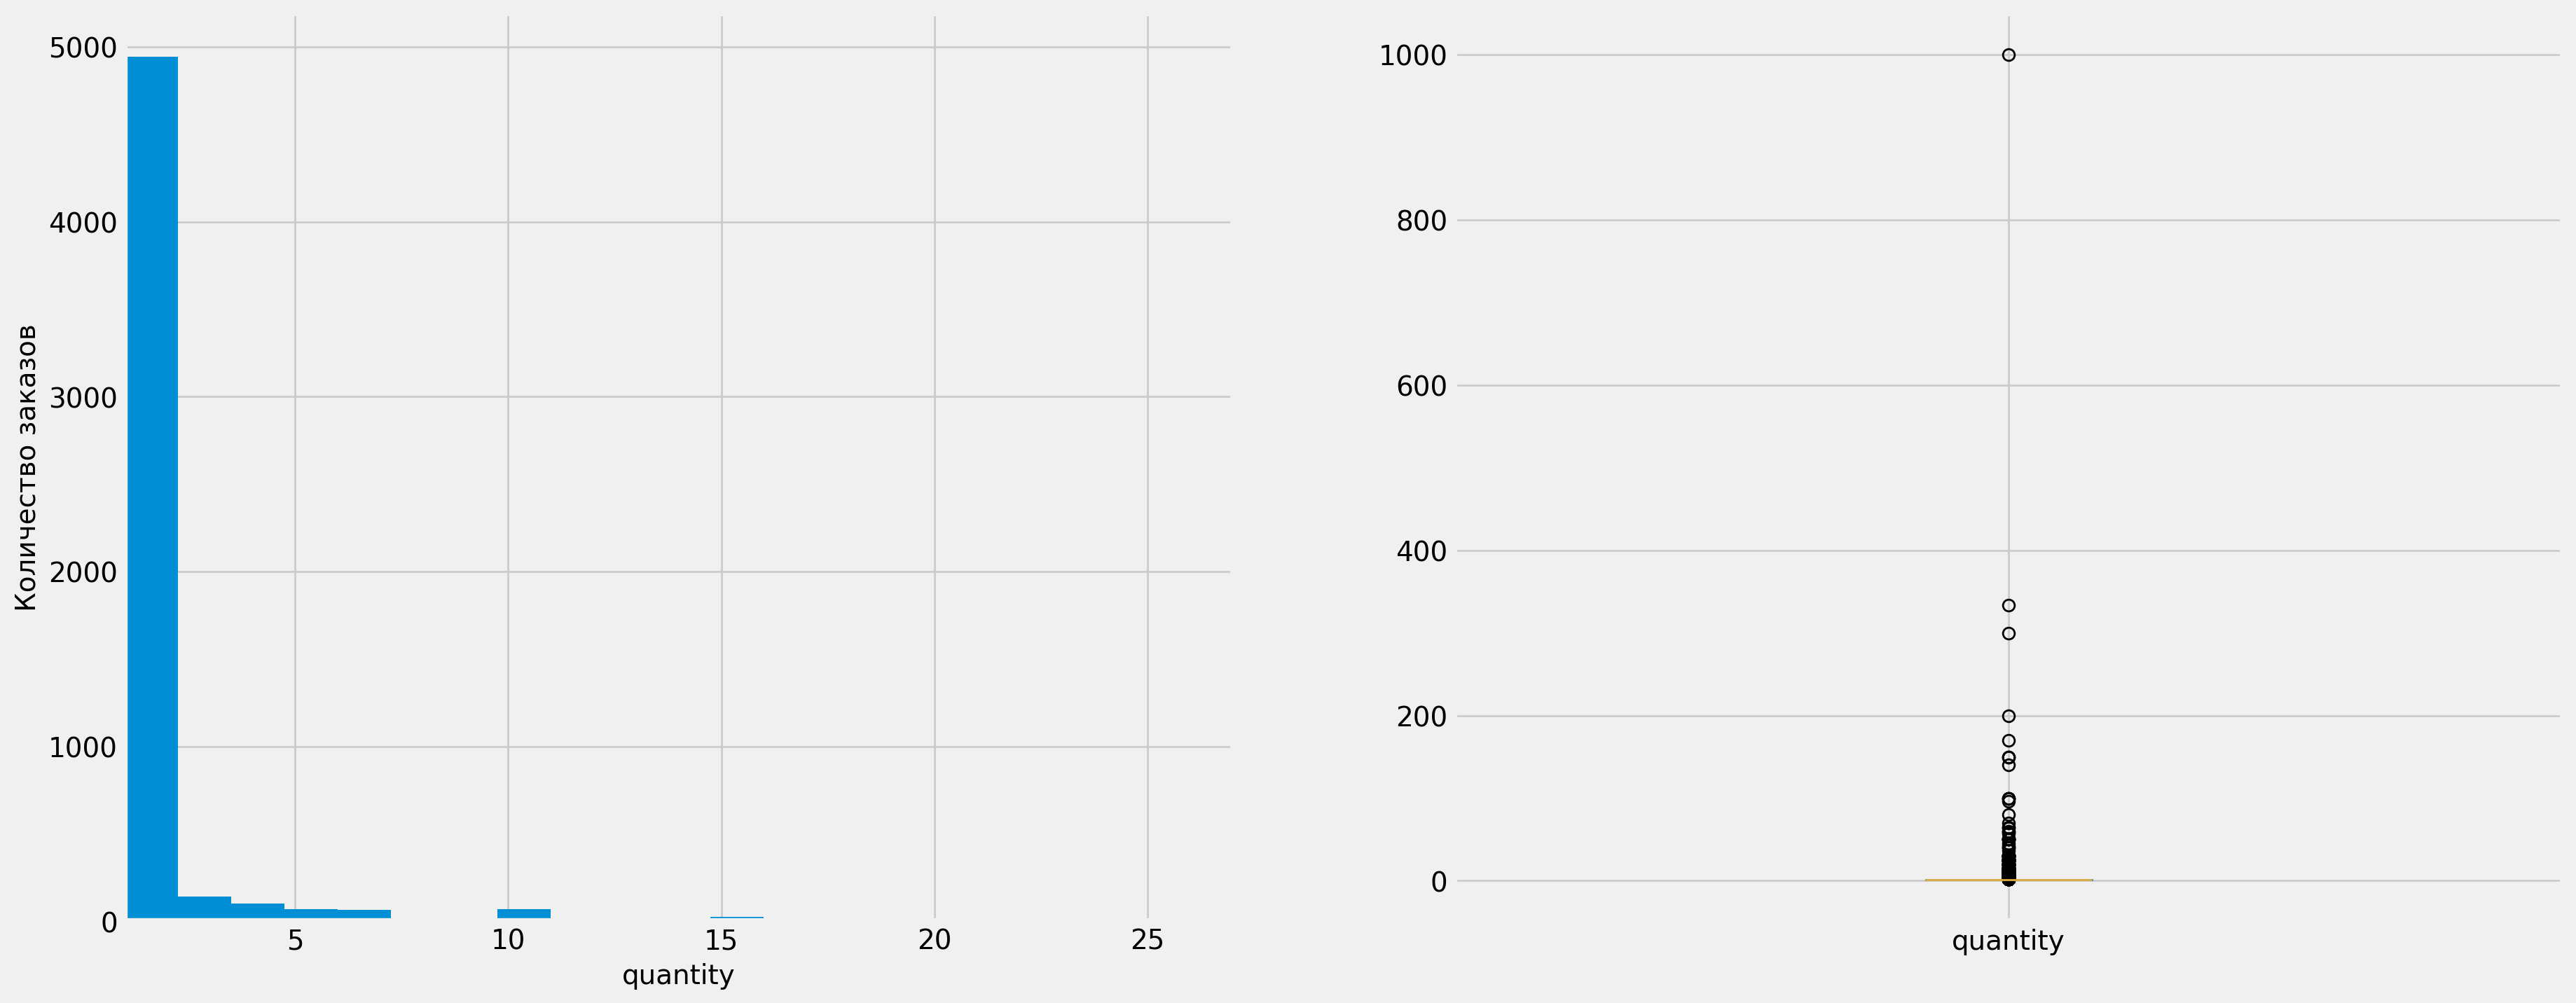

In [32]:
first_hist(data=store, column='quantity', h_bins=800)

In [33]:
print('50, 75, 95 и 99 перцентиль для количества товаров в заказе: ', 
      "{0:.0f}".format(np.percentile(store['quantity'], 50)), ', '
      "{0:.0f}".format(np.percentile(store['quantity'], 75)), ', '
      "{0:.0f}".format(np.percentile(store['quantity'], 95)), ', '
      "{0:.0f}".format(np.percentile(store['quantity'], 99)))

50, 75, 95 и 99 перцентиль для количества товаров в заказе:  1 , 1 , 6 , 27


Основная масса заказов приходится на столбец с заказами до 1 позиции товара в заказе. 75% заказов в данных только с 1 позицией товара в заказе. В исследовании важно получить среднестатистического пользователя по каждой категории пользователей, поэтому такие аномалии могут исказить результаты исследования. Но важно при этом не отсеить потенциальных покупателей, которые совершают оптовые заказы часто. Посмотрим на категорию топ-10 заказов по количеству товаров в заказе.

In [34]:
store.groupby(by='quantity', as_index=False)\
     .agg(total = ('order_id', 'nunique'),
          price_product = ('price', 'sum'),
          sum_order = ('revenue', 'sum'))\
     .sort_values(by='quantity', ascending=False)\
     .head(10)\
     .reset_index(drop=True)

quantity  total  price_product  sum_order
0      1000      1          675.0   675000.0
1       334      1          148.0    49432.0
2       300      1           51.0    15300.0
3       200      1           29.0     5800.0
4       170      1           51.0     8670.0
5       150      2           77.0    11550.0
6       140      1           59.0     8260.0
7       100      4          123.0    12300.0
8        96      1           38.0     3648.0
9        80      1           45.0     3600.0

Можно отметить, что в топе 10 присутствуют в основном единичные крупно оптовые заказы, причём по количеству товаров. Так как суммы за такие заказы могут быть разные, как 675 тыс рублей, так и 3600 тыс рублей. Поэтому по количеству товаров в заказе обрезать данные не целесообразно, важнее будет удалить аномалии по общей сумме заказа.

In [35]:
# Переменная для контроля % удалённых значений аномалий
del_anom = [0, store.shape[0]]

#### Цена заказа

Посмотрим на гистограмму для цены заказа.

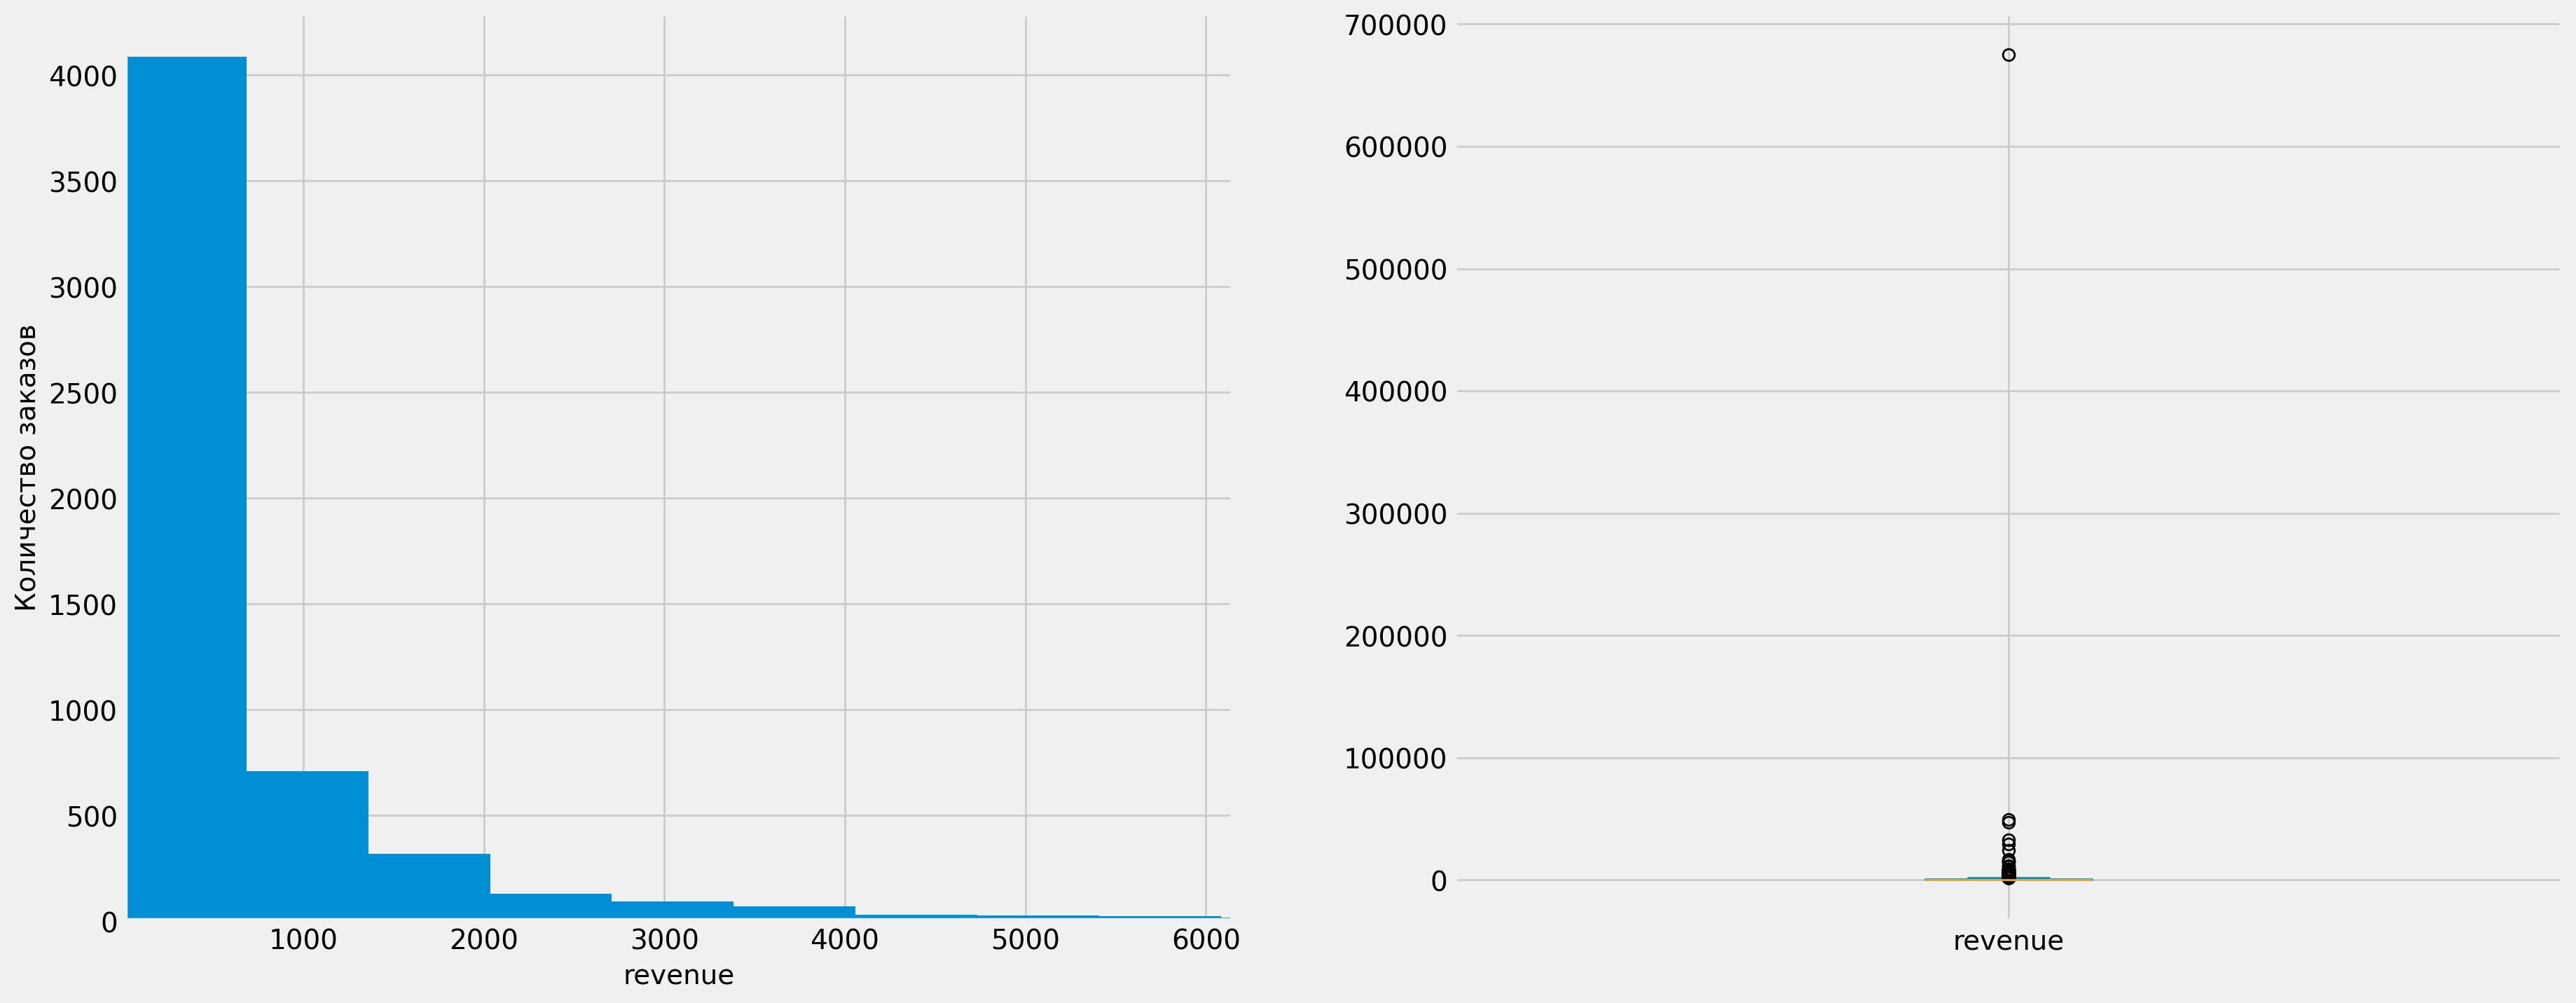

In [36]:
first_hist(data=store, column='revenue', h_bins=1000)

In [37]:
print('50, 75, 95 и 99 перцентиль для суммы заказа: ', 
      "{0:.0f}".format(np.percentile(store['revenue'], 50)), ', '
      "{0:.0f}".format(np.percentile(store['revenue'], 75)), ', '
      "{0:.0f}".format(np.percentile(store['revenue'], 95)), ', '
      "{0:.0f}".format(np.percentile(store['revenue'], 99)))

50, 75, 95 и 99 перцентиль для суммы заказа:  191 , 734 , 2850 , 6149


Основная масса заказов приходится на заказы до 1000 рублей. Есть единичный максимально нереальный выброс в 650 тыс рублей. Всё, что дороже 2000 рублей, считается выбросами. Видно, что суммы заказа больше 6 тыс рублей, находятся за гранью 99 перцентиля. Посмотрим подробнее на топ-10 заказов по потраченной сумме.

In [38]:
store.groupby(by='revenue', as_index=False)\
     .agg(total = ('order_id', 'nunique'),
          quantity = ('quantity', 'sum'),
          price_product = ('price', 'sum'))\
     .sort_values(by='revenue', ascending=False)\
     .head(10)\
     .reset_index(drop=True)

revenue  total  quantity  price_product
0  675000.0      1      1000          675.0
1   49432.0      1       334          148.0
2   47385.0      1        27         1755.0
3   32718.0      1        57          574.0
4   29248.0      1        64          457.0
5   24370.0      1         5         4874.0
6   16536.0      1         3         5512.0
7   15680.0      1        10         1568.0
8   15358.0      1         2         7679.0
9   15300.0      1       300           51.0

Из общей суммы заказа видно, что есть только 1 выбивающийся заказ из общей массы заказов - заказ на 675 тыс рублей. Все остальные находятся в рамках разумного для оптовых заказов (до 50 тыс рублей) на разные позиции товара. Из наших данных можно удалить это 1 значение, которое явно будет искажать результаты, как для обычных покупателей, так и для оптовых.

In [39]:
store = store.query('revenue != 675000').reset_index(drop=True)
del_anom[0] = store.shape[0]
del_value[0] = store.shape[0]

In [40]:
print('Процент удалённых значений: ', 
      "{0:.1%}".format((del_value[1] - del_value[0]) / del_value[1]))

Процент удалённых значений:  25.7%


#### Промежуточный вывод:

- За аномалию было принято 1 значение заказа на 650 тыс рублей.
- Общий процент удалённых значений из датафрейма равняется 25.7%.

### Промежуточные выводы

Была проведена предобработка данных:
- В данных не было явных дубликатов.
- В данных не было пропущенных значений.
- В данных были строчки с неявными дубликатами, которые возникли из-за периодичности выгрузки данных в течении дня.
- Было обнаружено 66 строчек с ошибкой в данных: одному id-заказу принадлежали разные id-пользователя.
- Были удалены строчки с неявными дубликатами, их количество составило 25% от данных датафрейма.
- Был выделен столбец с категорией товаров.
- Данные были проверены на аномалии, есть выбивающиеся заказы по количеству товаров в заказе и по цене товара за заказ. Такие аномалии были оставленны в данных.
- Были добавлены столбцы с месяцем заказа и общей ценой за заказ.
- Было удалено всего 1 значение заказа на общую сумму в 650 тыс рублей.
- Данные подготовлены для дальнейшего анализа.

## Исследовательский анализ данных

### Сезонность покупок

Посмотрим, за какое время предоставлены данные:

In [41]:
print('Начальная дата заказа: ', store['date_out_time'].min())
print('Финальная дата заказа: ', store['date_out_time'].max())
print('Промежуток заказов: ', store['date_out_time'].max() - store['date_out_time'].min())

Начальная дата заказа:  2018-10-01
Финальная дата заказа:  2020-01-31
Промежуток заказов:  487 days, 0:00:00


Данные предоставлены с 1 октября 2018 года по 31 января 2020 года. Таким образом, только за 2019 год будут полные данные, а для 2018 года предоставлено только 3 месяца и для 2020 года только 1 месяц.

Посмотрим на динамику по продажам по месяцам.

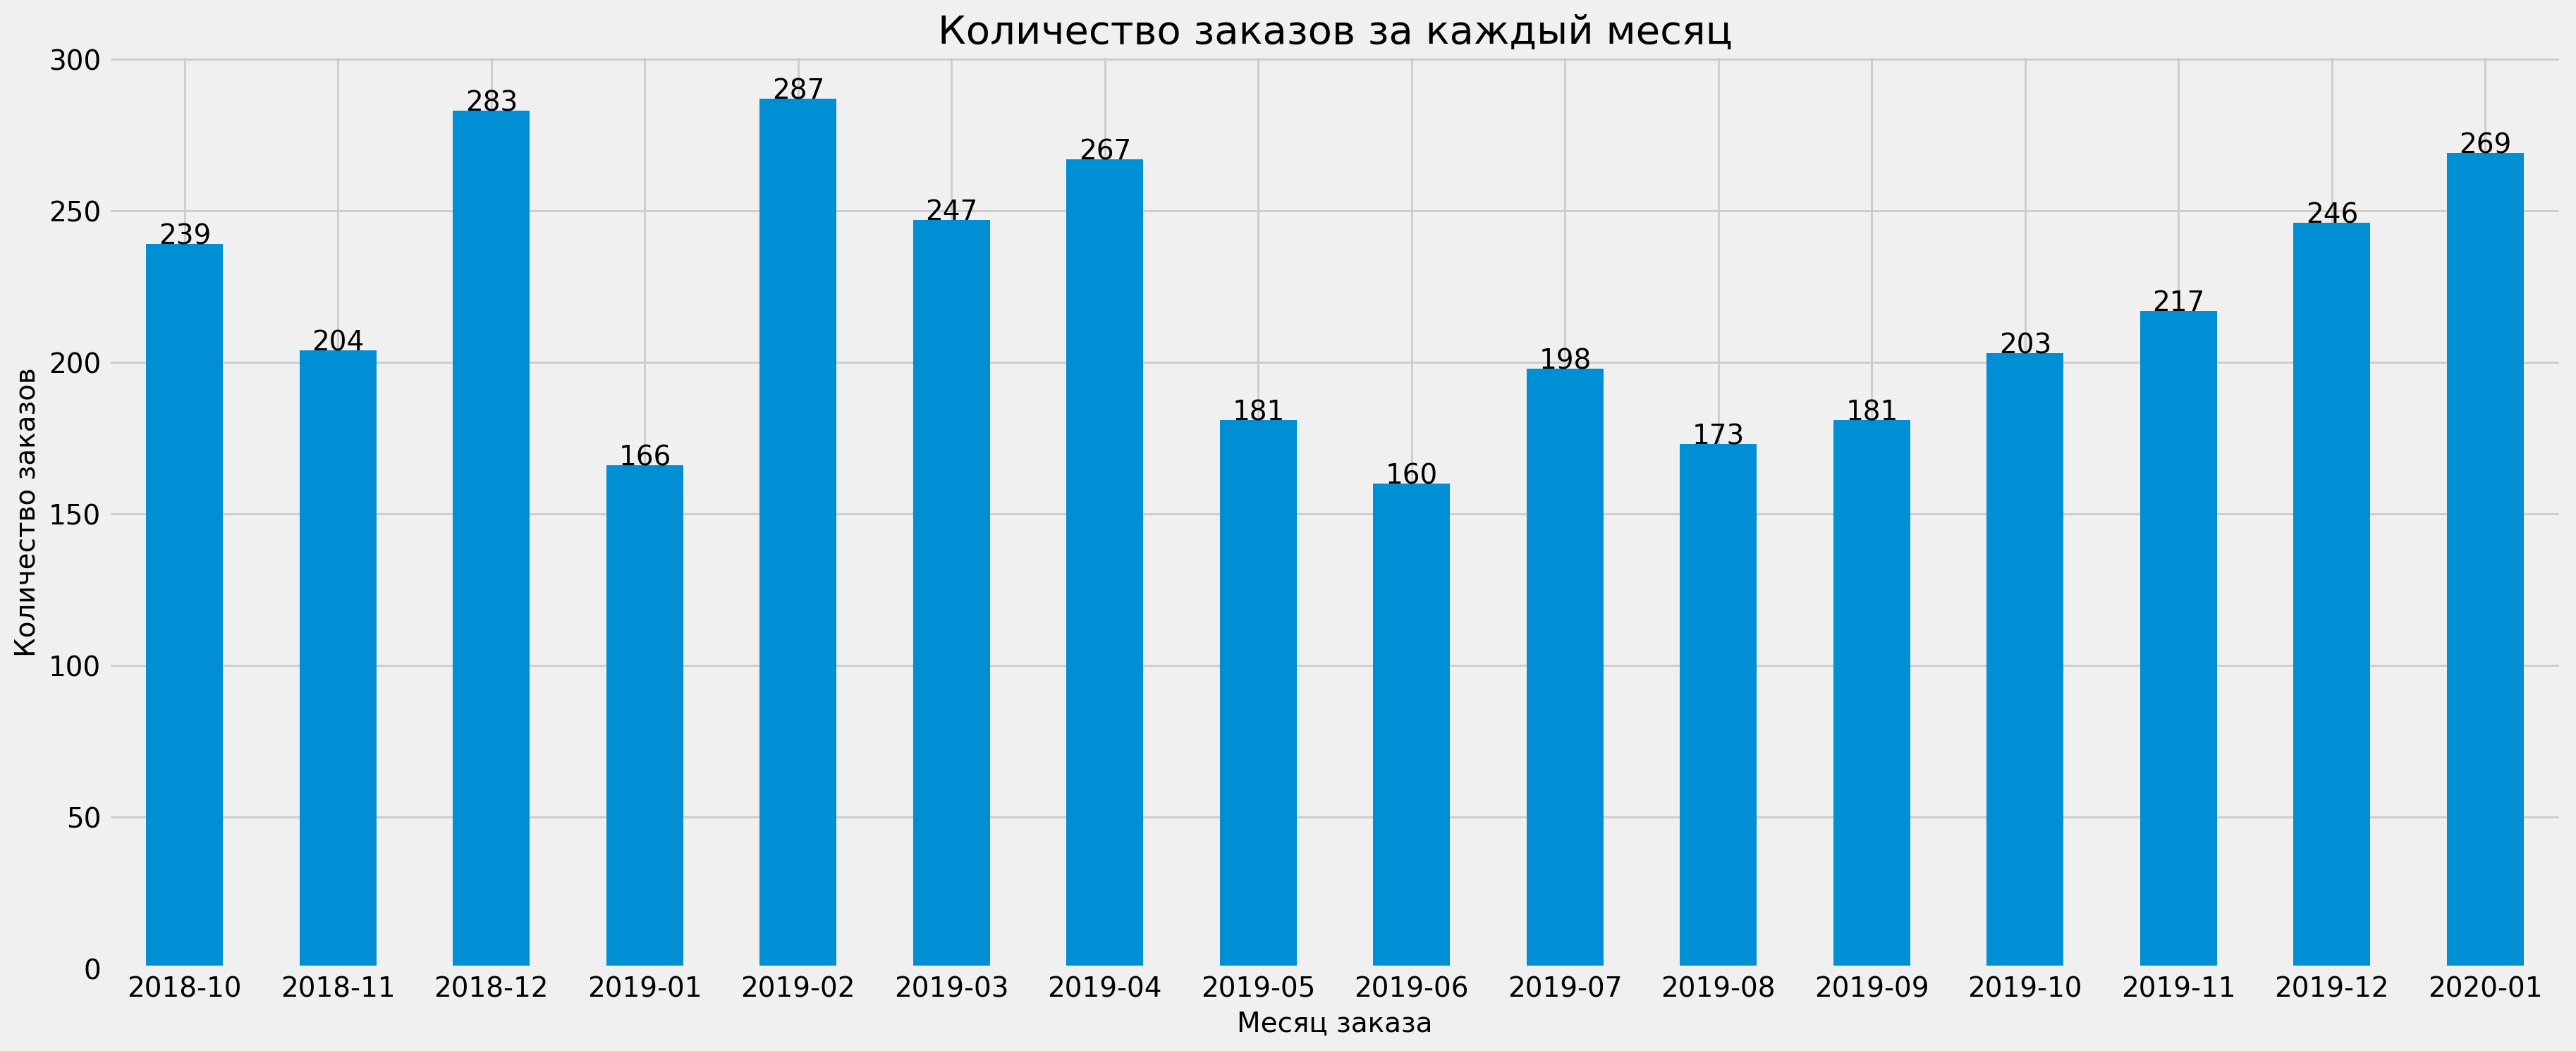

In [42]:
df = table_pivot(store, 'month', 'order_id', 'nunique')
fig = bar_plot(df, 'month', 'total')
plt.xticks(rotation=0)
addlabels(x=df['month'], y=df['total'])
plt.xlabel('Месяц заказа')
plt.ylabel('Количество заказов')
plt.title('Количество заказов за каждый месяц')
plt.show();

Количество заказов зависит от месяца совершения покупки. Так, январь 2020 года входит в топ-3 месяцев по количеству заказов, зато в январе 2019 года количество заказов было одно из наименьших, меньше только в июне. С февраля по апрель 2019 года приходится много заказов, в мае и июне наблюдается сильная просадка, зато с июля 2019 года и до января 2020 года наблюдается плавный рост.

In [43]:
df = table_pivot(store, 'month', 'revenue', 'median')
fig = bar_plot(df, 'month', 'total')
plt.xticks(rotation=0)
addlabels(x=df['month'], y=df['total'])
plt.xlabel('Месяц заказа')
plt.ylabel('Медианная сумма заказа')
plt.title('Медианная сумма заказа за каждый месяц')
plt.show();

С марта по май 2019 года самые маленькие медианные чеки заказов. Самый большой медианный чек наблюдается в декабре 2018 года, при том, что в этот месяц и по количеству заказов он был один из лидеров. Также с августа по октябрь 2019 года медианный чек заказа достаточно высокий.

Можно разбить на сезоны: зима, весна, лето, осень и посмотреть, как менялась покупательская способность в таком случае.

In [44]:
store['season'] = store.apply(season, axis=1)

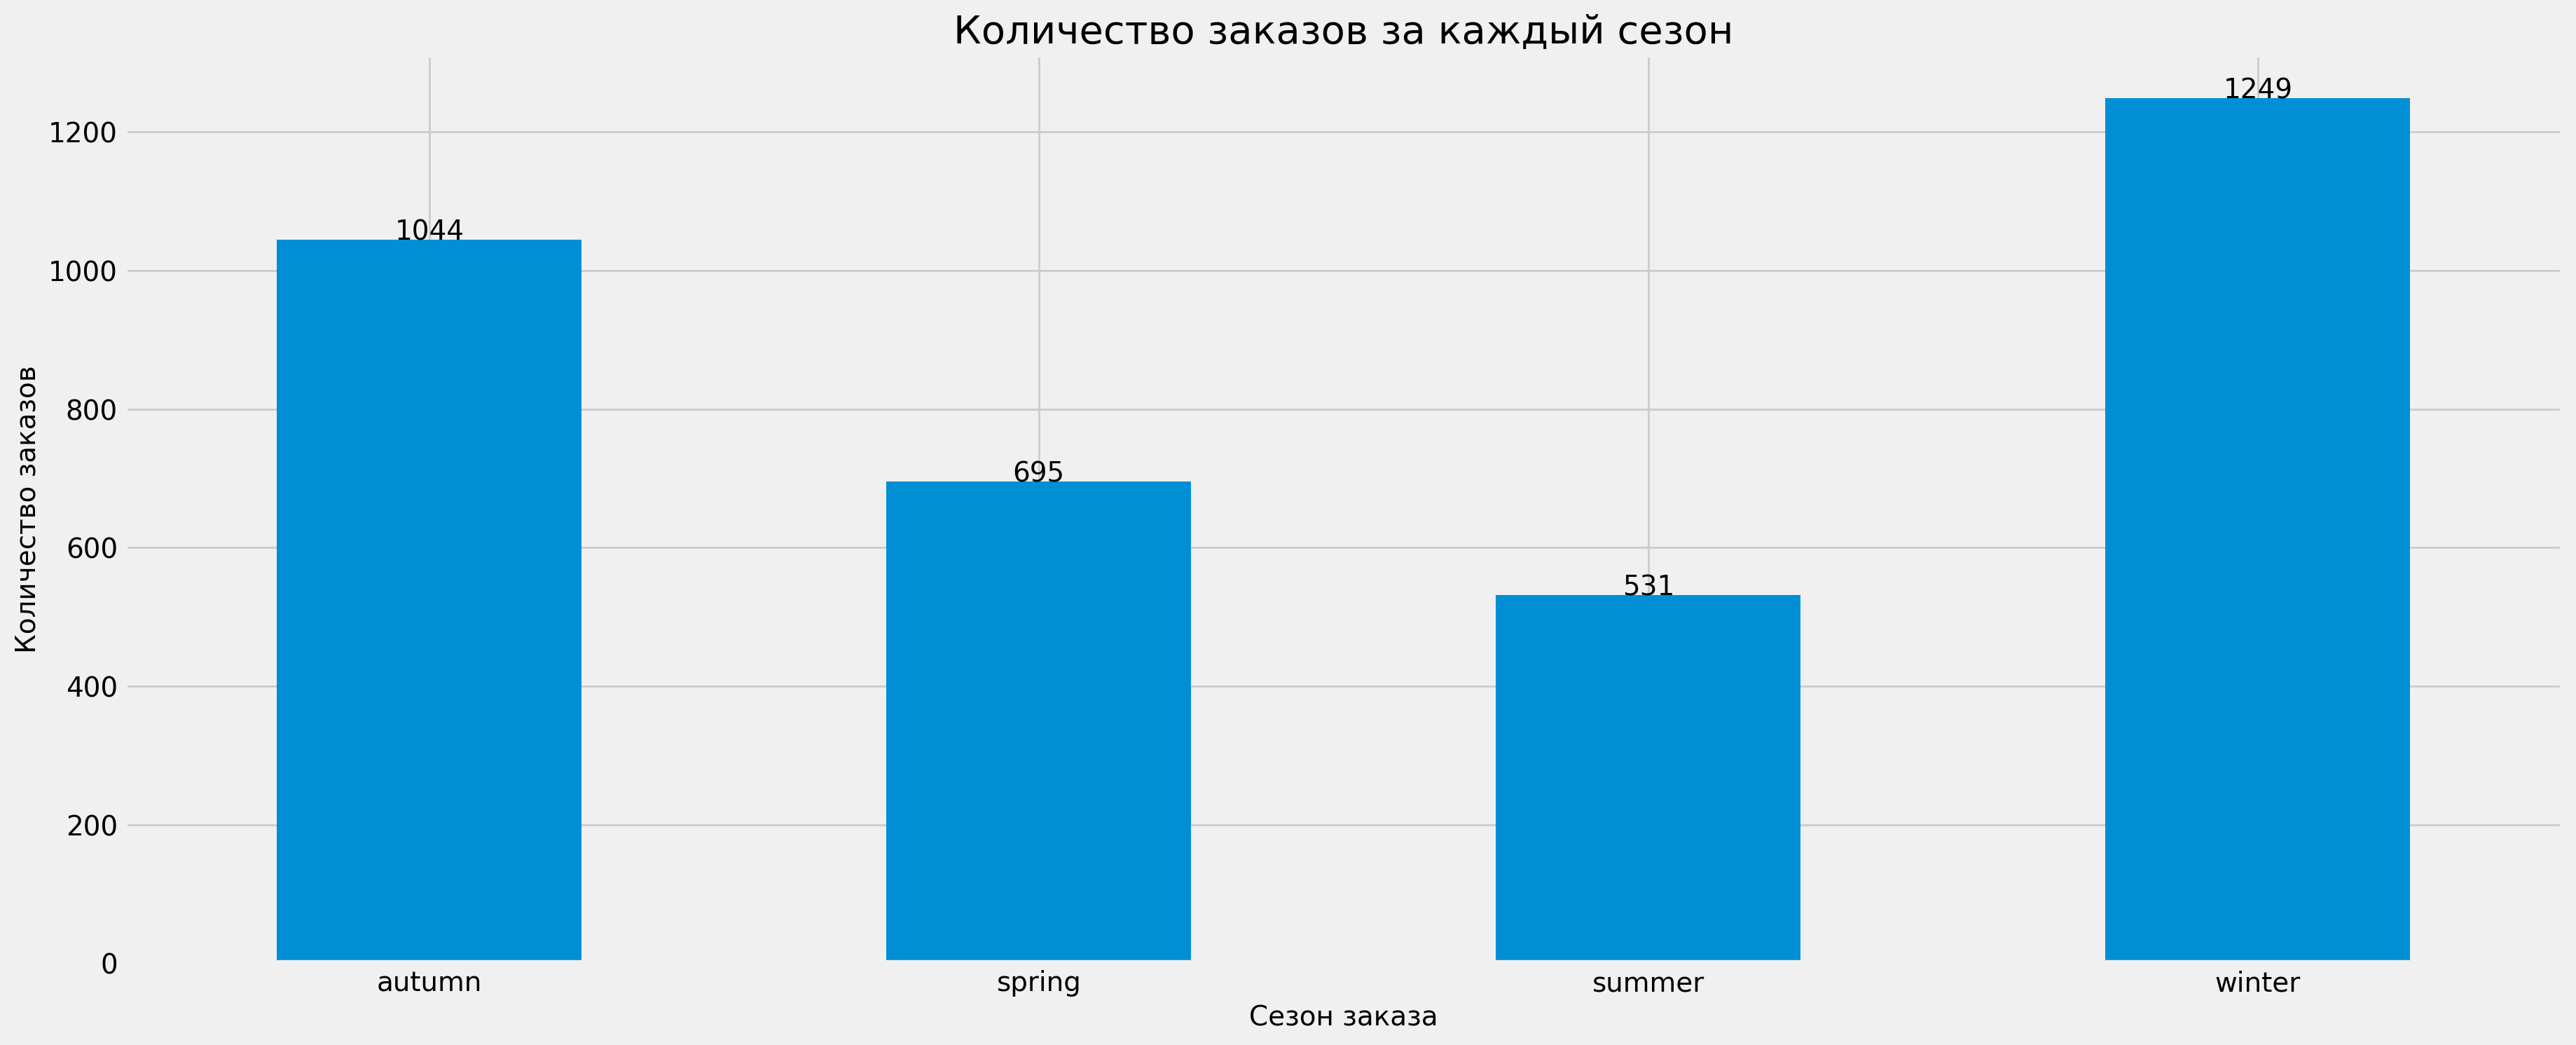

In [45]:
df = table_pivot(store, 'season', 'order_id', 'nunique')
fig = bar_plot(df, 'season', 'total')
plt.xticks(rotation=0)
addlabels(x=df['season'], y=df['total'])
plt.xlabel('Сезон заказа')
plt.ylabel('Количество заказов')
plt.title('Количество заказов за каждый сезон')
plt.show();

Больше заказов было зимой и осенью, что объясняется тем, что в эти сезоны попали части данных за 2018 и 2020 года. Но то, что весной заказов больше, чем летом, можно объяснить ассортиментом магазина: весной многие покупают цветы и саженцы, чтобы подготовиться к лету.

In [46]:
df = table_pivot(store, 'season', 'revenue', 'median')
fig = bar_plot(df, 'season', 'total')
plt.xticks(rotation=0)
addlabels(x=df['season'], y=df['total'])
plt.xlabel('Сезон заказа')
plt.ylabel('Медианная сумма заказа')
plt.title('Медианная сумма заказа за каждый сезон')
plt.show();

Можно отметить, что зима находится на первом месте по потраченным на заказы деньгам. На втором месте находится осень, а на последнем весна. Значит, хоть за весну происходит больше заказов по количеству, чем летом, по среднему чеку эти заказы не являются дорогостоящими. Вполне вероятно, в это время года многие покупают не сильно дорогие семена цветов и рассаду. А зимой происходят дорогостоящие покупки, так как зимой есть праздник НГ, на который многие покупают технику и дорогие бытовые товары.

### Сезонность категорий покупок

Посмотрим на категории покупок по сезонам.

In [47]:
# определение цветовой палитры для групп
color_plot = dict(zip(store['product_category'].unique(), 
                      px.colors.qualitative.Plotly))

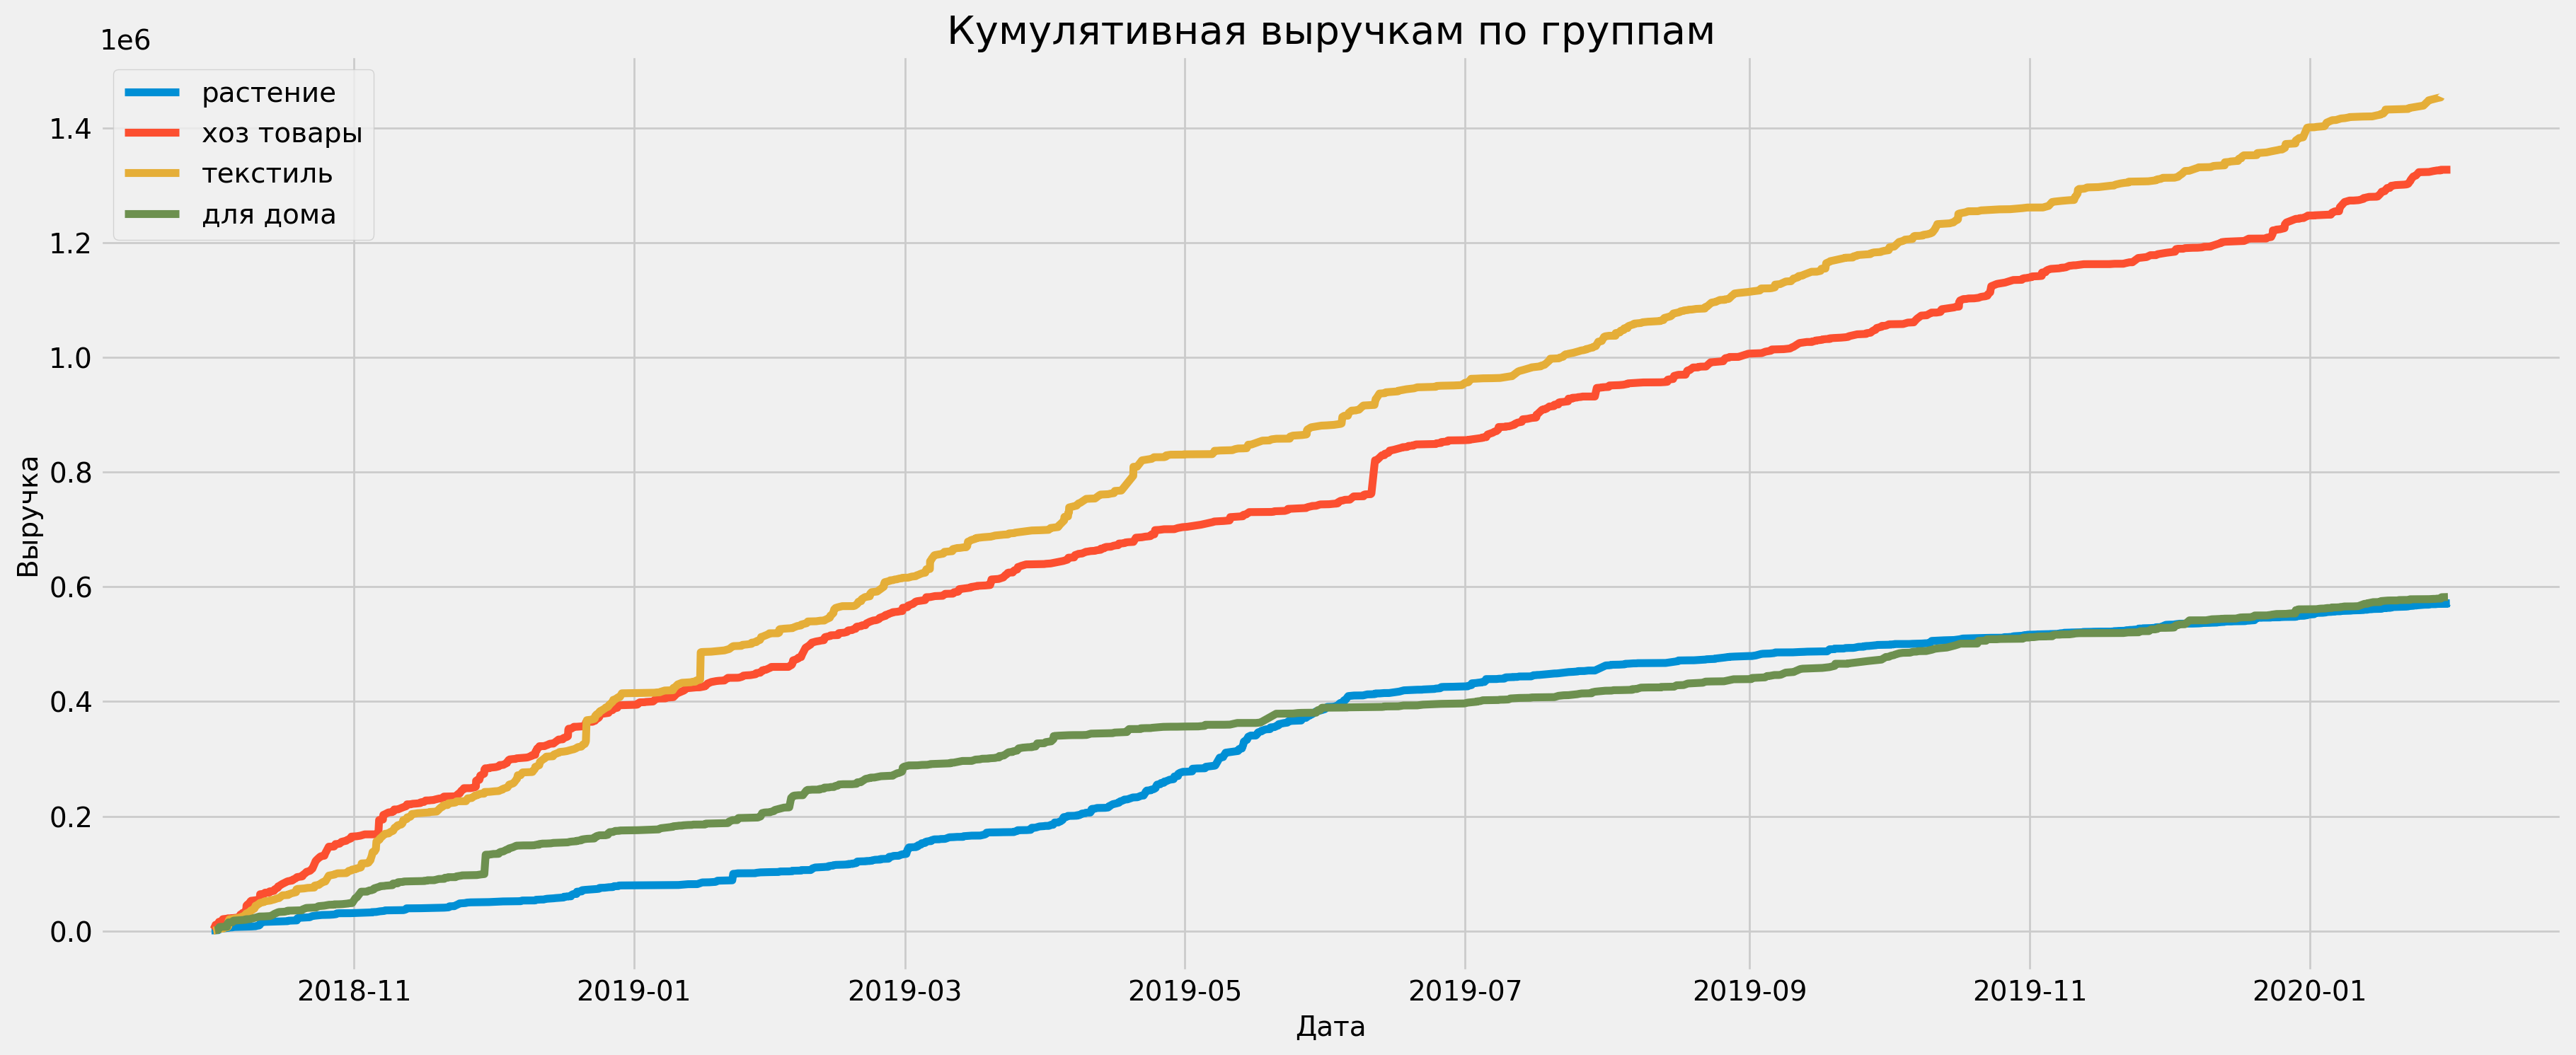

In [48]:
cumulativeRevenue = orders_agg(store, 'product_category')
fig = plot_agg(cumulativeRevenue, 'revenue', 'product_category')
plt.xticks(rotation=0)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручкам по группам')
plt.legend
plt.show();

По кумулятивной выручке можно отметить, что самыми прибыльными направлениями для бизнеса являются хоз товары и текстиль - спрос на эти категории имеется каждый сезон. А вот растения и товары для дома имеют более выраженную сезонность: после июня растения практически не покупали, а товары для дома слабо покупали до марта 2019 года, потом резко возрос спрос, но который затих после июня 2019 года.

In [49]:
df = table_pivot(store, ['season', 'product_category'], 'order_id', 'nunique')
fig = plot_bar(df, 'total', 'product_category', 'season')
fig.update_traces(texttemplate='%{text:.0f}',textfont_size=10, textangle=0)
fig.update_layout(xaxis_title='Количество заказов',
                  yaxis_title='Категория',
                  legend_title='Сезон',
                  title='Количество заказов по категориям за сезон')
fig.show();

Хоз товары, текстиль и растения являются самыми популярными категориями по общему числу заказов. При этом можно отметить, что весной на заметные позиции выходит категория растения, а летом по этой категории заказов меньше, чем в другие сезоны. Летом меньше заказов на товары для дома (посуда, техника, мебель), зато зимой по этой категории больше всего заказов.

Для того, чтобы изучить динамику среднего чека по группам, необходимо разделить кумулятивную выручку на кумулятивное количество.

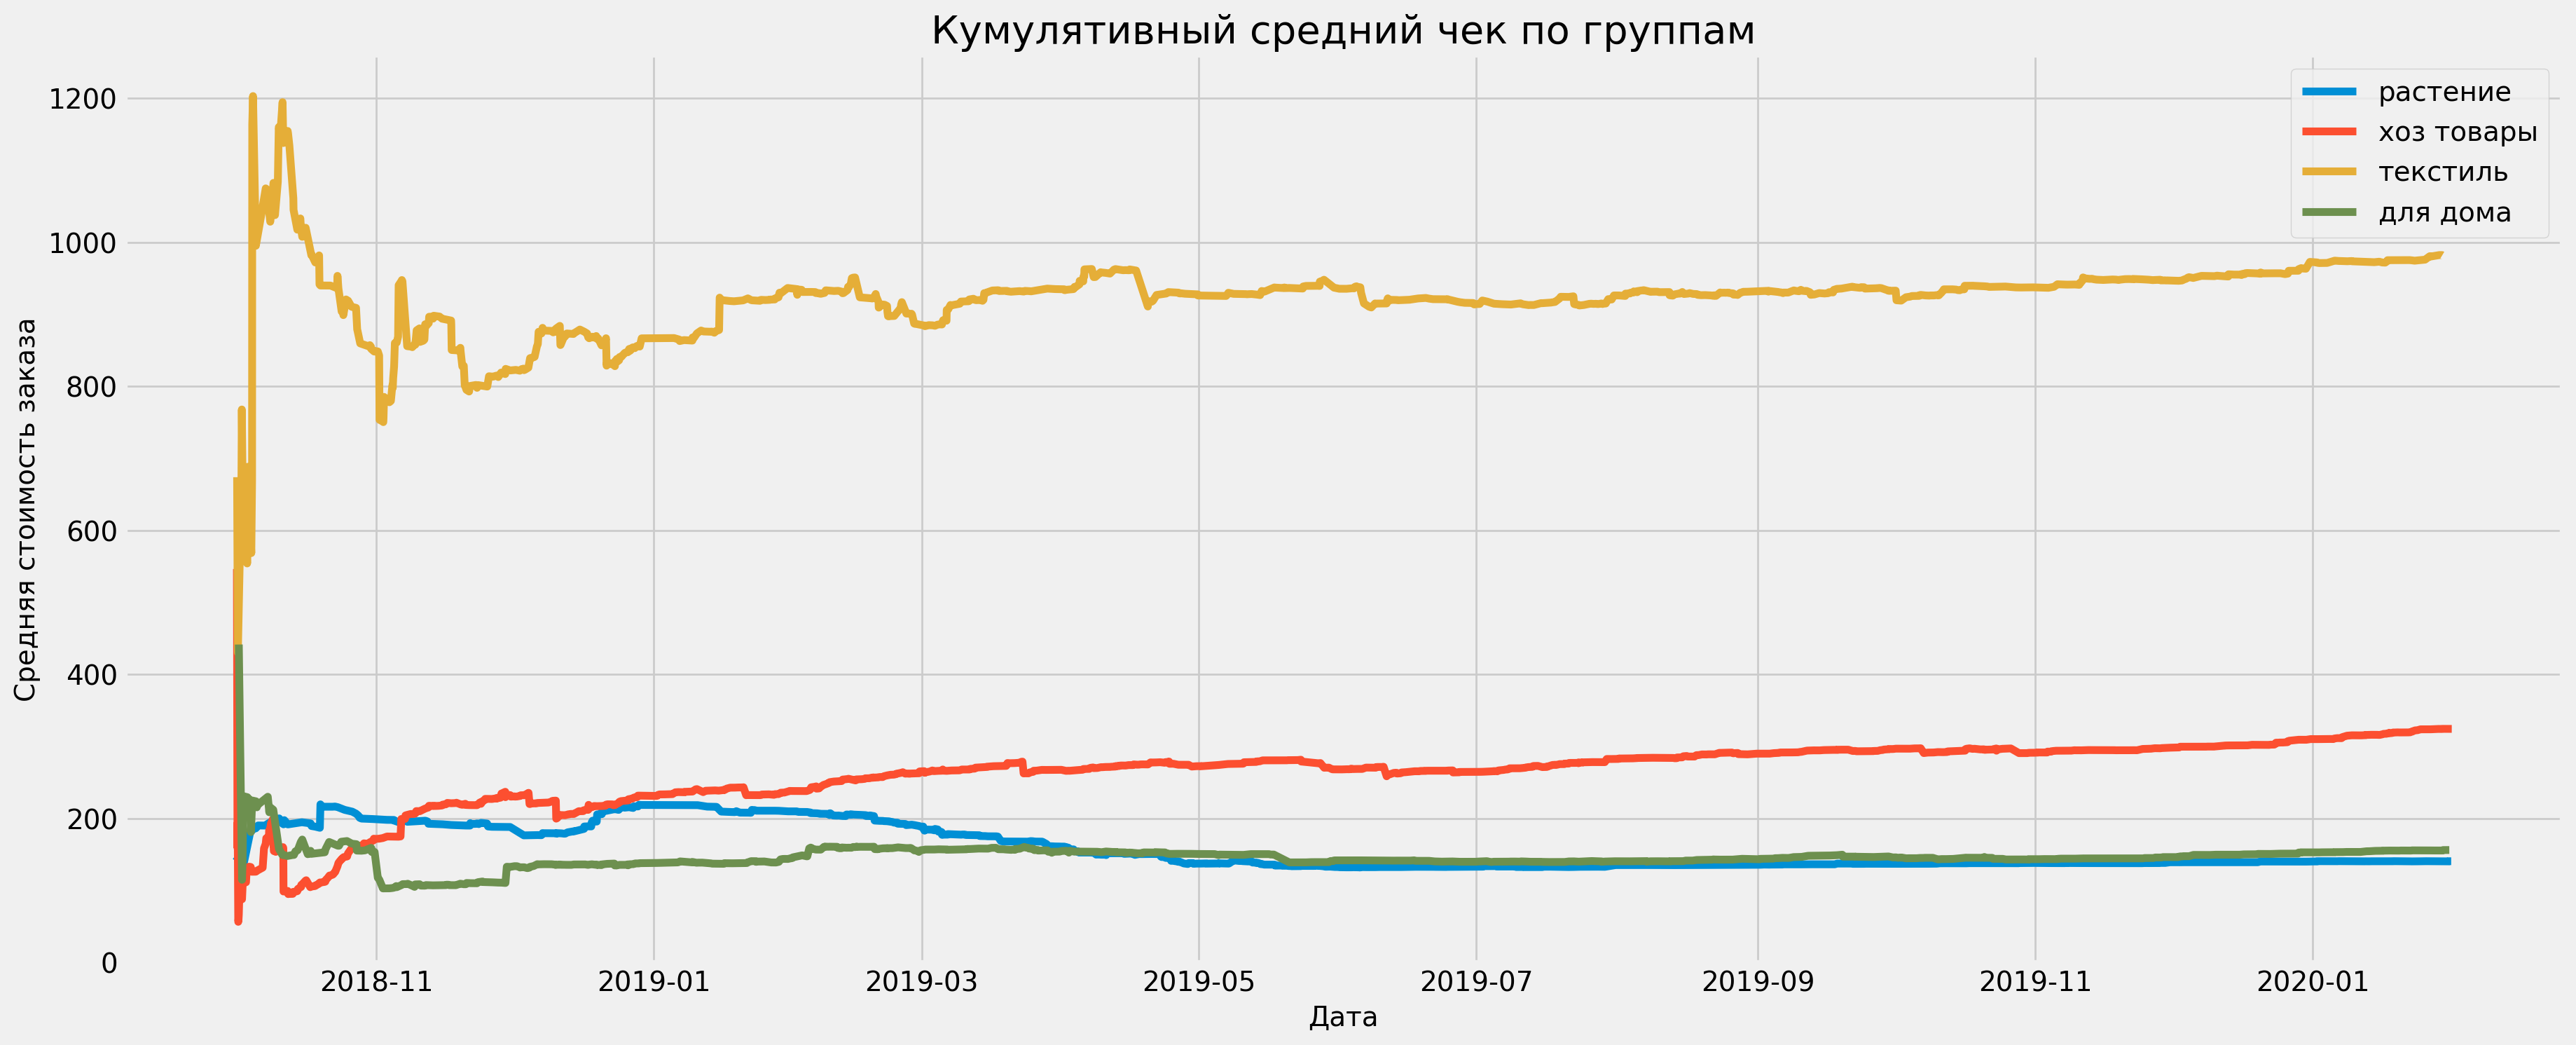

In [50]:
cumulativeRevenue['avg_price'] = cumulativeRevenue['revenue'] / cumulativeRevenue['quantity']
fig = plot_agg(cumulativeRevenue, 'avg_price', 'product_category')
plt.xticks(rotation=0)
plt.xlabel('Дата')
plt.ylabel('Средняя стоимость заказа')
plt.title('Кумулятивный средний чек по группам')
plt.legend
plt.show();

Можно отметить, что в октябре 2018 года наблюдалась очень крупная по стоимости покупка в категории текстиля. В целом, средний чек заказов из этой категории на протяжении всего времени был выше, чем для остальных категорий. Также можно отметить категорию хоз товаров, которая к концу времени исследования по среднему чеку вышла на второй по значимости уровень. А вот для категорий растения и товаров для дома всё время наблюдется маленький средний чек.

Посмотрим на медианный чек по категориям покупок.

In [51]:
fg = table_pivot(store, ['season', 'product_category'], 'revenue', 'median')
fig = plot_bar(df, 'total', 'product_category', 'season')
fig.update_layout(xaxis_title='Медианная сумма заказа',
                  yaxis_title='Категория',
                  legend_title='Сезон',
                  title='Медианная сумма заказов по категориям за сезон')
fig.show();

Средний чек заказа практически не зависит от сезона покупки. Зато можно отметить, что самой дорогой категорией является текстильная продукция, а наименее дорогой - растение (скорее всего, из-за большого количества таких товаров, как семена и саженцы в этой категории, которые стоят дёшево). 

### Оптовые покупки

Посмотрим на категории товаров, в которых берут большое количество единиц товара (от 10 штук).

In [52]:
df = table_pivot(store, 'order_id', 'quantity', 'sum')
print('Процент оптовых товаров: ', 
      "{0:.1%}".format(df.query('total >= 10')['total'].count() / df['total'].count()))

Процент оптовых товаров:  8.7%


Их всех данных заказов с количеством товара от 10 и более всего 8.7%.

In [53]:
df = table_pivot(store.query('quantity >= 10'), ['season', 'product_category'], 
                 'order_id', 'nunique')
fig = plot_bar(df, 'total', 'product_category', 'season')
fig.update_layout(xaxis_title='Количество заказов',
                  yaxis_title='Категория',
                  legend_title='Сезон',
                  title='Количество оптовых заказов по категориям за сезон')
fig.show();

Популярными категориями для оптовых закупок являются товары для дома и хоз товары. Также можно отметить рост числа оптовых заказов на растения весной.

### Промежуточные выводы

- На январь 2019 и июнь в 2019 году приходилось минимум заказов.
- С июля 2019 года до января 2020 года наблюдался рост числа заказов.
- На декабрь 2018, февраль и апрель 2019 приходится максимум числа заказов.
- С марта по май 2019 года были самые маленькие медианные чеки заказов.
- Самый большой медианный чек был в декабре 2018 года.
- Больше всего заказов происходит зимой, а на лето приходится меньше всего заказов. 
- Самой дорогой категорией товаров является текстильная продукция, а наименее дорогой - растения.
- Медианный чек заказов пркатически не зависит от сезона года.
- Популярными для оптовых закупок являются категории: товары для дома и хоз товары.
- Весной растёт число оптовых заказов на растения.

## Сегментация покупателей

### Выделение категорий покупателей

Проведём укрупнённый RFM анализ для выделения категорий покупателей.

In [54]:
temp = ['customer_id', 'order_id', 'date_out_time', 'revenue']
RFM_data = store[temp]
RFM_data.shape

(5551, 4)

In [55]:
NOW = store['date'].max().date()
# RFM Table
RFM_table = RFM_data.groupby(by=['customer_id'], as_index=False)\
                    .agg({'date_out_time': lambda x: (NOW - x.max()).days, # Recency
                          'order_id': lambda x: len(x.unique()), # Frequency
                          'revenue': lambda x: x.sum()})    # Monetary 

RFM_table['date_out_time'] = RFM_table['date_out_time'].astype(int)

RFM_table.rename(columns={'date_out_time': 'recency', 
                          'order_id': 'frequency',
                          'revenue': 'monetary_value'}, inplace=True)

In [56]:
RFM_table.describe().style.format('{:.1f}')

В основном частота покупок пользователей составляет от 1 до 2 заказов. Таким образом, в RFM сегментации можно оставить частоту покупок, как: 1 раз - редко, 2 и более - часто. Выделим такие категории:
- Активные: 
    - делали покупки недавно (позже середины ноября 2019 года), больше 1 заказа, больше 800 р за заказ.
- Лояльные: 
    - делали покупки недавно (позже середины ноября 2019 года), больше 1 заказа, меньше 800 р за заказ
    - делали покупки недавно (позже середины ноября 2019 года), 1 заказ, больше 800 р за заказ
    - делали покупки не очень давно (не раньше середины ноября 2019 г, но не позже начала января 2019 г), больше 1 заказа и больше 800 р за заказ.
- Спящие:
    - делали покупки недавно (позже середины ноября 2019 года), 1 заказ, меньше 800 р за заказ
    - делали покупки не очень давно (не раньше середины ноября 2019 г, но не позже начала января 2019 г), больше 1 заказа и меньше 800 р за заказ.
    - делали покупки не очень давно (не раньше середины ноября 2019 г, но не позже начала января 2019 г), 1 заказ и больше 800 р за заказ.
- Уходящие:
    - делали покупки не очень давно (не раньше середины ноября 2019 г, но не позже начала января 2019 г), 1 заказ и меньше 800 р за заказ.
- Потерянные:
    - делали покупки очень давно (раньше января 2019 года)

In [57]:
quantiles = RFM_table[['recency', 'frequency', 'monetary_value']].quantile([0.25, 0.5, 0.75])
quantiles

recency  frequency  monetary_value
0.25     73.0        1.0           389.0
0.50    210.0        1.0           836.0
0.75    344.0        2.0          1798.0

In [58]:
quantil = quantiles.to_dict()

#  RFM Segmentation
RFM_Segment = RFM_table.copy()
    
RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency', quantil,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency', quantil,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary_value'].apply(FM_Class, args=('monetary_value', quantil,))
RFM_Segment['RFM'] = RFM_Segment.R_Quartile.map(str) + \
                          RFM_Segment.F_Quartile.map(str) + \
                          RFM_Segment.M_Quartile.map(str)
RFM_Segment['RFM'] = RFM_Segment['RFM'].astype(int)
RFM_Segment['RFMClass'] = RFM_Segment['RFM'].apply(RFM_Class)

In [59]:
RFM_Segment.groupby('RFMClass')['RFMClass'].count()

RFMClass
active      363
leaving     573
lost        599
loyal       394
sleeping    500
Name: RFMClass, dtype: int64

Образовались группы с примерно одинаковым количеством пользователей в каждой из них. Присоединим номер группы к нашей изначальной таблице.

In [60]:
store_rfm = store.merge(RFM_Segment[['customer_id', 'RFMClass']], on='customer_id')
store_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5551 entries, 0 to 5550
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              5551 non-null   datetime64[ns]
 1   customer_id       5551 non-null   object        
 2   order_id          5551 non-null   int64         
 3   product           5551 non-null   object        
 4   quantity          5551 non-null   int64         
 5   price             5551 non-null   float64       
 6   product_category  5551 non-null   object        
 7   revenue           5551 non-null   float64       
 8   date_out_time     5551 non-null   object        
 9   month             5551 non-null   period[M]     
 10  num_month         5551 non-null   int64         
 11  season            5551 non-null   object        
 12  RFMClass          5551 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6), period[M](1)
memory usa

### Метрики по каждой категории

#### Средний чек и количество заказов

Посмотрим на количество заказов и медианный чек покупок по каждой из категории пользователей.

In [61]:
store_rfm.groupby(by='RFMClass', as_index=False)\
         .agg(total_order = ('order_id', 'nunique'),
              revenue_median = ('revenue', 'median'))

RFMClass  total_order  revenue_median
0    active          726           749.0
1   leaving          573           164.0
2      lost          674           277.0
3     loyal          948           188.0
4  sleeping          598           142.0

Медианные чеки по каждой категории отличаются. Так, для категории активных покупателей самый большой медианный чек, а количество заказов больше у лояльной категории. Для категории потерянных медианный чек не сильно ниже, чем для лояльных, и не сильно выше, чем для спящих, но количество заказов меньше всего.

#### Категории товаров

Посмотрим на распределение категорий товаров по группам покупателей.

In [62]:
df = table_pivot(data=store_rfm, col_group=['RFMClass', 'product_category'], 
                 values='order_id', func='nunique')
fig = plot_bar(df, 'total', 'product_category', 'RFMClass')
fig.update_layout(xaxis_title='Количество заказов',
                  yaxis_title='Категория',
                  legend_title='Группа',
                  title='Количество заказов по категориям для групп пользователей')
fig.show();

Наибольшим спросом у всех групп пользуются такие категории: хоз товары, текстиль и растения, а наименьшим - товары для дома. Для активных пользователей товары для дома пользуются меньшей популярностью, на первом месте у них хоз товары и текстиль. Для лояльных пользователей на первом месте категория растений, как и для спящих пользователей и уходящих. Но при этом для уходящих на последнем месте по спросу находится текстиль. Для потерянных пользователей категория растений была наименее популярной.

Посмотрим на общую сумму покупок по каждой категории для групп пользователей.

In [63]:
df = table_pivot(data=store_rfm, col_group=['RFMClass', 'product_category'], 
                 values='revenue', func='sum')
fig = plot_bar(df, 'total', 'product_category', 'RFMClass')
fig.update_traces(texttemplate='%{text:.0f}',textfont_size=10, textangle=0)
fig.update_layout(xaxis_title='Сумма заказов',
                  yaxis_title='Категория',
                  legend_title='Группа',
                  title='Сумма заказов по категориям для групп пользователей')
fig.show();

Больше всего пользователи тратили деньги на категорию хоз товары и текстиль, а на товары для дома и растения приходятся примерно одинаковые доли. При этом у активных пользователей на хоз товары и текстиль ушла примерна одинаковая сумма, а у спящих пользователей категория хоз товаров находится на первом месте с большим отрывом от других категорий. У группы потерянных больше всего денег потрачено было на категорию текстиль.

Посмотрим на медианный чек заказов по категориям товаров для групп пользователей.

In [64]:
df = table_pivot(data=store_rfm, col_group=['RFMClass', 'product_category'], 
                 values='revenue', func='median')
fig = plot_bar(df, 'total', 'product_category', 'RFMClass')
fig.update_traces(texttemplate='%{text:.0f}',textfont_size=10, textangle=0)
fig.update_layout(xaxis_title='Медианная сумма заказа',
                  yaxis_title='Категория',
                  legend_title='Группа',
                  title='Медианная сумма заказа по категориям для групп пользователей')
fig.show();

По медианному чеку заказов можно отметить, что для категории растений он для всех групп одинаков и занимает последнее место, а на лидирующих позициях находятся текстиль и хоз товары. У группы спящих для хоз товаров больший медианный чек, чем для категории текстиль.

#### Сезонность покупок

Посмотрим на сезонность покупок для сегментов покупателей.

In [65]:
df = table_pivot(data=store_rfm, col_group=['RFMClass', 'season'], 
                 values='order_id', func='nunique')
fig = plot_bar(df, 'total', 'season', 'RFMClass')
fig.update_traces(texttemplate='%{text:.0f}',textfont_size=10, textangle=0)
fig.update_layout(xaxis_title='Количество заказов',
                  yaxis_title='Сезон',
                  legend_title='Группа',
                  title='Количество заказов по сезонам для групп пользователей')
fig.show();

Активные пользователи большую часть своих заказов совершали в зимний период, как и лояльные пользователи. Спящие - осенью и весной. Потерянные были активными только в зимний и осенний период, в уходящие - весной и летом.

### Сезонность категорий товаров для групп

Посмотрим для каждой группы пользователей, какие категории товаров пользовались спросом по каким сезонам.

In [66]:
product = table_pivot(data=store_rfm, col_group=['RFMClass', 'product_category', 'season'], 
                      values='order_id', func='nunique')

In [67]:
# определение цветовой палитры для групп
color_plot = dict(zip(product['season'].unique(), 
                      px.colors.qualitative.Plotly))

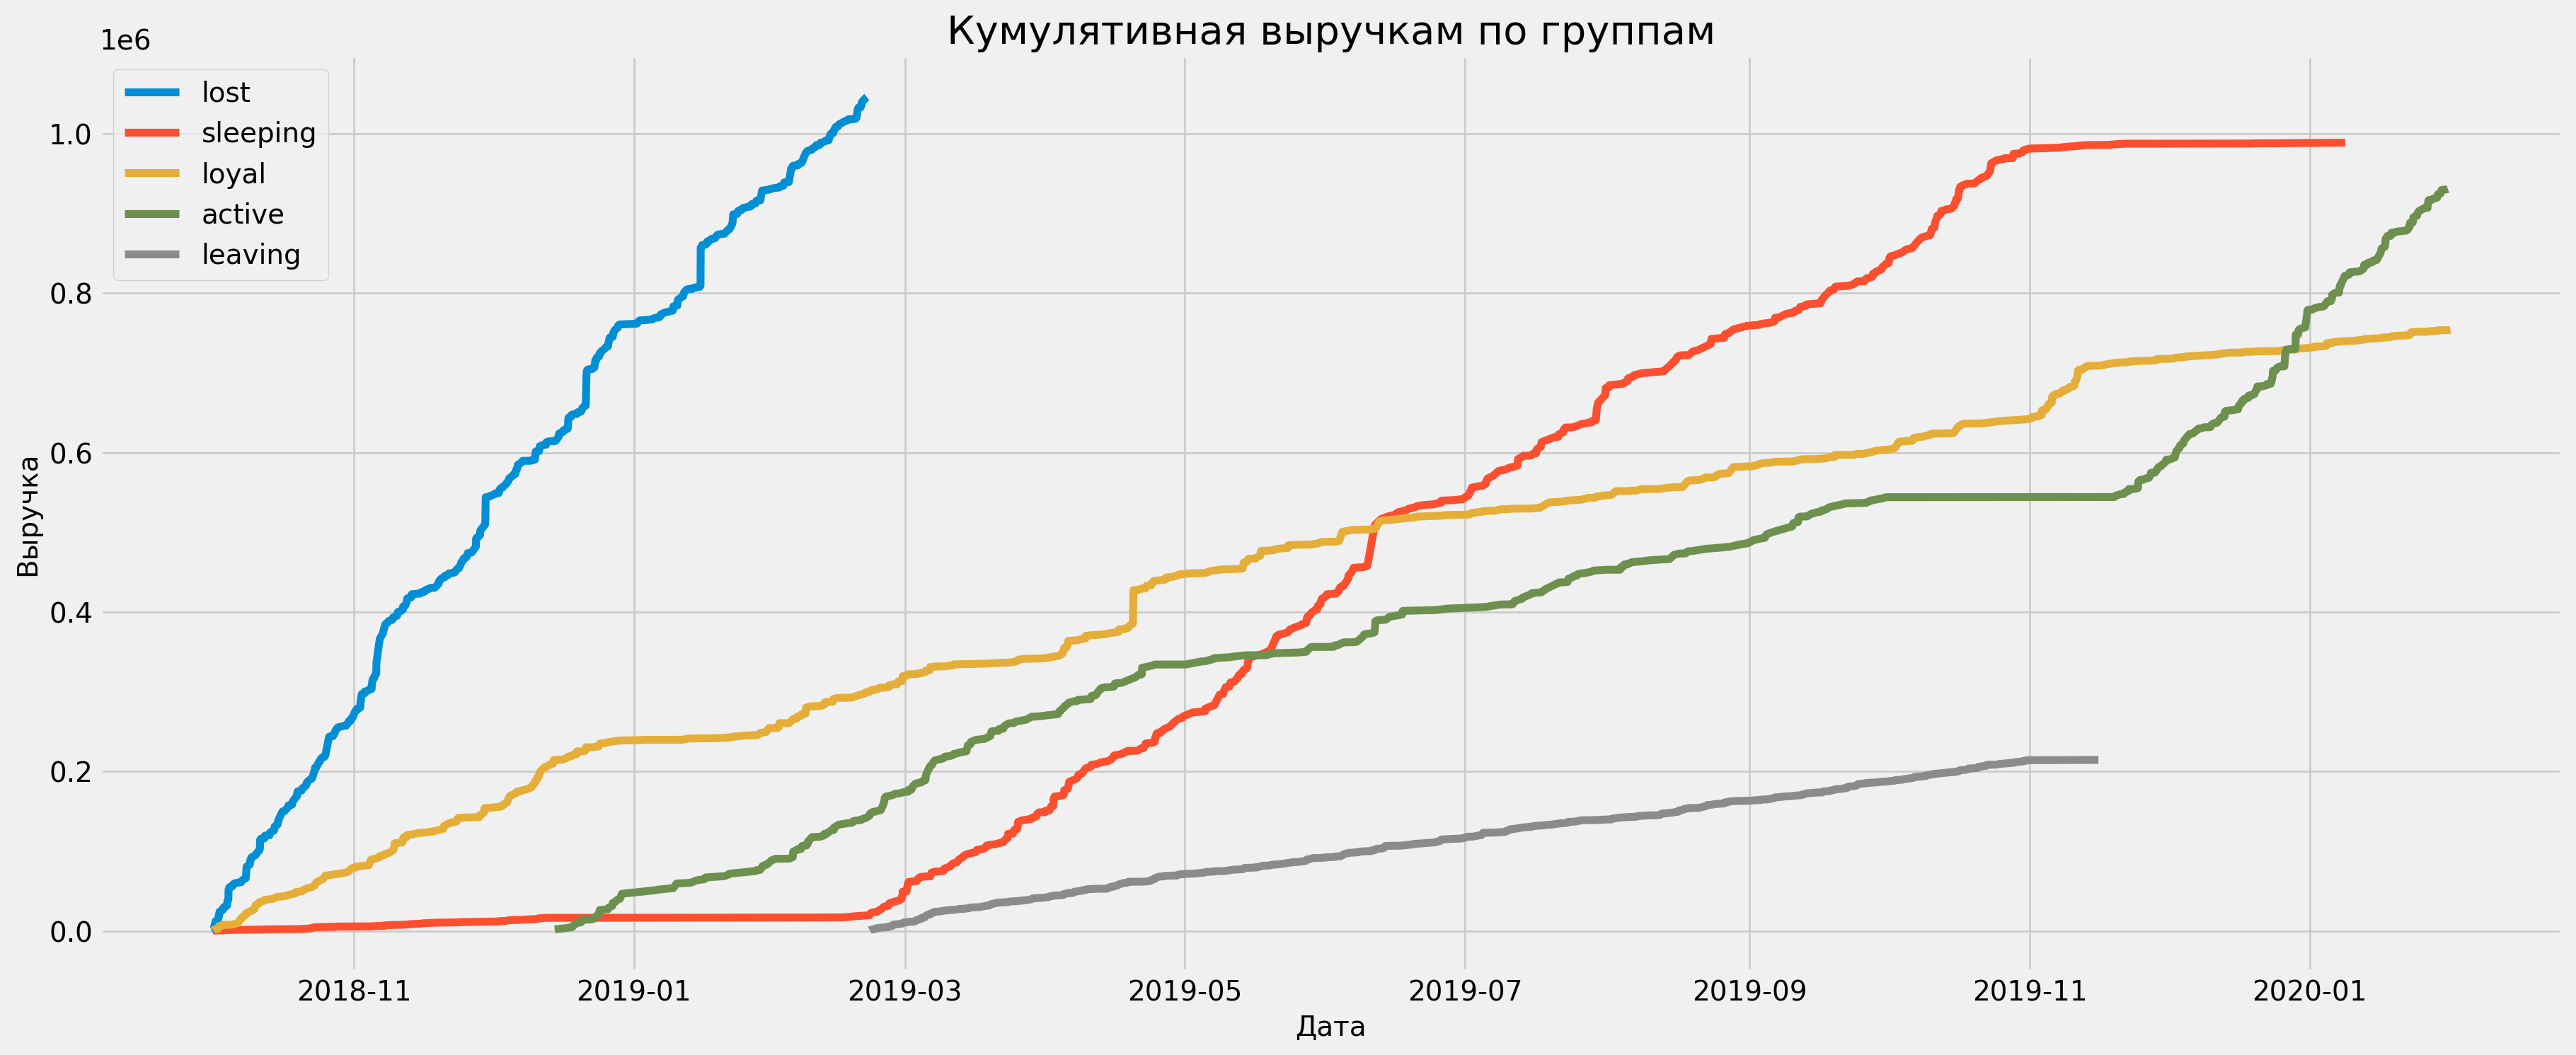

In [68]:
cumulativeRevenue = orders_agg(store_rfm, 'RFMClass')
fig = plot_agg(cumulativeRevenue, 'revenue', 'RFMClass')
plt.xticks(rotation=0)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручкам по группам')
plt.legend
plt.show();

Потерянные пользователи приносили неплохую доходность магазину, но с марта 2019 года эта группа была потеряна. Уходящие пользователи были активны с марта по ноябрь 2019 года, но активны слабо. Хотя и выручка от них росла каждый месяц. Что интересно, группа спящих пользователей была неактивна до марта 2019 года, потом резко включилась в совершение покупок, каждый месяц до ноября 2019 года выручка от них увеличивалась, но с ноября они перестали покупать. Лояльные и активные пользователи показывают хорошую динамику на протяжении всего анализируемого промежутка по времени. Но по общей сумме выручки ни лояльные ни активные пользователи ещё не дошли до показателей потерянных и спящих. Что говорит о том, что неплохо бы обратить внимание на возвращение группы спящих пользователей.

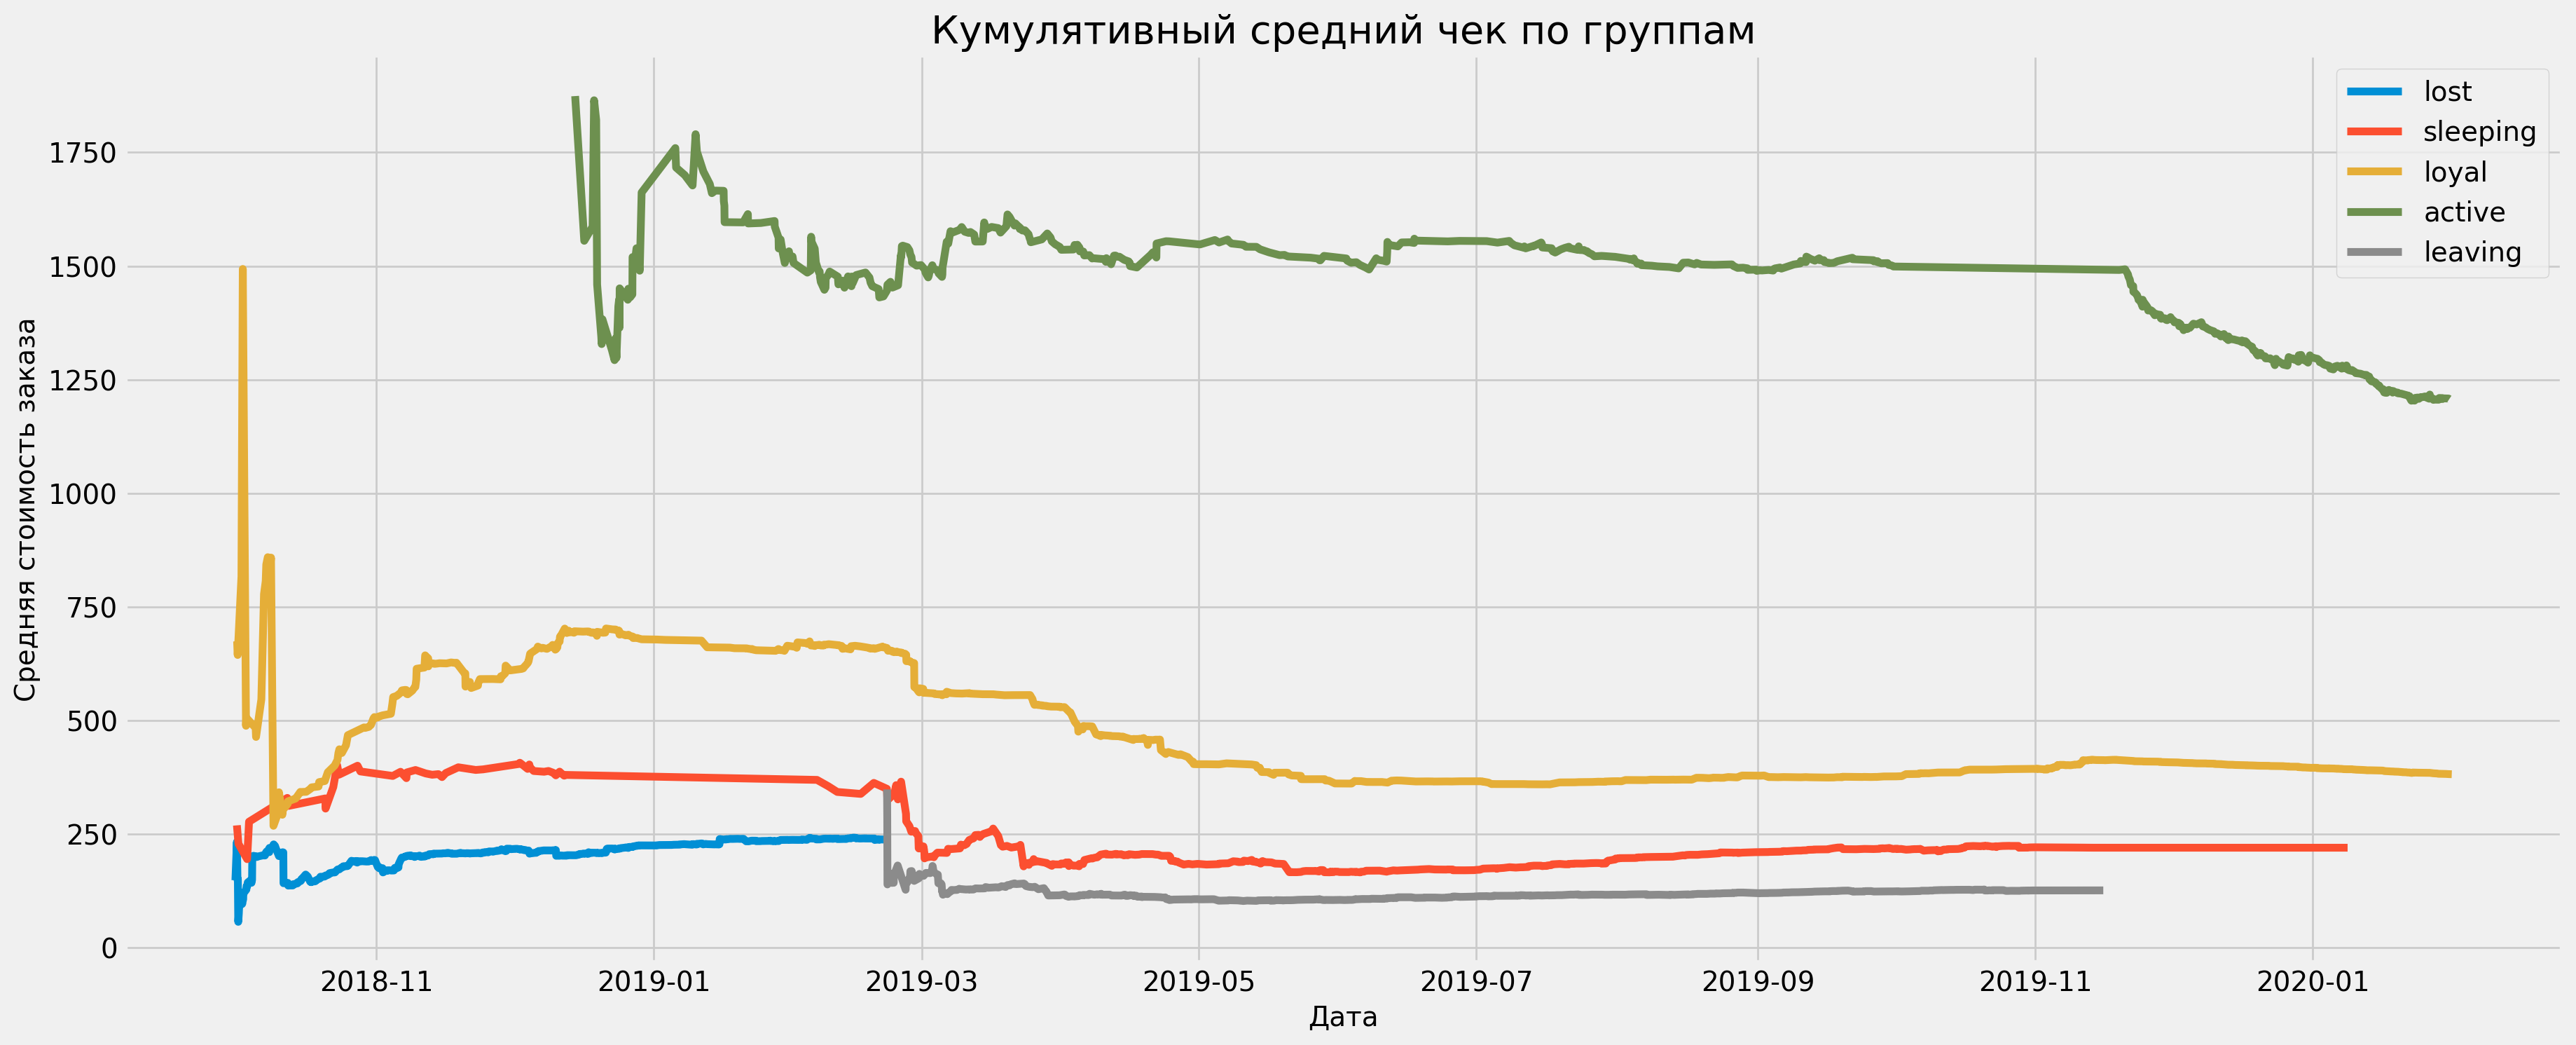

In [69]:
cumulativeRevenue['avg_price'] = cumulativeRevenue['revenue'] / cumulativeRevenue['quantity']
fig = plot_agg(cumulativeRevenue, 'avg_price', 'RFMClass')
plt.xticks(rotation=0)
plt.xlabel('Дата')
plt.ylabel('Средняя стоимость заказа')
plt.title('Кумулятивный средний чек по группам')
plt.legend
plt.show();

Можно отметить, что группа активных пользователей имеет наилучшие показатели по среднему чеку среди остальных групп. На втором месте находятся лояльные пользователи, которые ещё и иногда совершали большие заказы. А вот группа уходящих слабо себя проявила в качестве покупок в интернет-магазине.

#### Активные

In [70]:
fig = plot_bar(product.query('RFMClass == "active"'), 'total', 'product_category', 'season')
fig.update_layout(xaxis_title='Количество заказов',
                  yaxis_title='Категория',
                  legend_title='Сезон',
                  title='Количество заказов по сезонам и товарам для активных пользователей')
fig.show();

Активные пользователи делали больше всего заказов по всем категориям зимой. Осенью в лидеры по количеству заказов вышли категории текстиль и растения, а во все остальные сезоны сохранялись хоз товары и текстиль. Категория для дома была наименее востребована во все сезоны.

#### Лояльные

In [71]:
fig = plot_bar(product.query('RFMClass == "loyal"'), 'total', 'product_category', 'season')
fig.update_layout(xaxis_title='Количество заказов',
                  yaxis_title='Категория',
                  legend_title='Сезон',
                  title='Количество заказов по сезонам и товарам для лояльных')
fig.show();

Лояльные пользователи делали больше всего заказов по категории растения, эта категория была в лидерах зимой и весной. Летом и осенью на первое место вышли хоз товары. Товары для дома больше продавались зимой, чем в другие сезоны.

#### Спящие

In [72]:
fig = plot_bar(product.query('RFMClass == "sleeping"'), 'total', 'product_category', 'season')
fig.update_layout(xaxis_title='Количество заказов',
                  yaxis_title='Категория',
                  legend_title='Сезон',
                  title='Количество заказов по сезонам и товарам для спящих')
fig.show();

Спящие пользователи чаще покупали по категории растения. Весной эта категория выходила в значительные лидеры по количеству заказов. Категория для дома продавалась хуже всего почти за все сезоны. Осенью, чаще заказы были из категории хоз товары, а летом из категории текстиль.

#### Уходящие

In [73]:
fig = plot_bar(product.query('RFMClass == "leaving"'), 'total', 'product_category', 'season')
fig.update_layout(xaxis_title='Количество заказов',
                  yaxis_title='Категория',
                  legend_title='Сезон',
                  title='Количество заказов по сезонам и товарам для уходящих')
fig.show();

Уходящие пользователи больше покупок делали по категории растения по все сезоны, особенно лидерство проявлялось весной. Зимой у них было меньше всего заказов.

#### Потерянные

In [74]:
fig = plot_bar(product.query('RFMClass == "lost"'), 'total', 'product_category', 'season')
fig.update_layout(xaxis_title='Количество заказов',
                  yaxis_title='Категория',
                  legend_title='Сезон',
                  title='Количество заказов по сезонам и товарам для потерянных')
fig.show();

Потерянные пользователи покупали только осенью и зимой. Больше всего заказов было по категории хоз товары, а меньше всего по категории растений. Зимой больше продавалась категория для дома.

### Промежуточные выводы

- Покупатели были поделены на 5 категорий в зависимости от среднего чека их заказов, частоты и давности покупок.
- Для категории активных пользователей самый большой медианный чек и количество заказов. 
- Для категории спящих пользователей медианный чек не сильно выше, чем для уходящих и потерянных.
- Наибольшим спросом у всех групп пользуются категории: хоз товары, текстиль и растения, а наименьшим - товары для дома.
- У группы активных на первом месте находится категория хоз товаров, а на последнем - товары для дома.
- У группы лояльных пользователей, уходящих и спящих на первом месте находится категория растений.
- Для уходящих на последнем месте по спросу находится текстиль, а для потерянных - категория растений.
- Больше всего пользователи тратили деньги на категорию хоз товаров, на втором месте находится текстиль.
- На товары для дома и растения приходятся примерно одинаковые доли по потраченным суммам.
- У спящих пользователей категория хоз товаров находится на первом месте с большим отрывом от других категорий.
- У группы потерянных больше всего денег потрачено было на категорию текстиль.
- Медианный чек заказов для категории растений для всех групп одинаков и занимает последнее место.
- На лидирующих позициях по медианному чеку находятся текстиль и хоз товары.
- Активные пользователи большую часть своих заказов совершали в зимний период, как и лояльные пользователи. 
- Спящие были активны осенью и весной. 
- Потерянные были активными только в зимний и осенний период, в уходящие - весной и летом.

Активные:
- Зимой меньше всего покупают по категории для дома, а больше всего хоз товары. 
- Весной больше всего покупали по категории хоз товаров и текстильную продукцию, а меньше всего товаров для дома.
- Летом покупали хоз товары и текстиль, в категории растения и для дома они были слабо активны.
- Осенью делали больше всего покупок по категории текстиль и растения, а меньше всего в товарах для дома.

Лояльные:
- Зимой покупают больше всего из категории растения, а меньше всего текстиль.
- Весной больше всего покупали из категории растений, а меньше всего для дома.
- Летом больше всего покупали хоз товары и растения, а меньше всего для дома.
- Осенью лидировали категории растения и текстиль, на последнем месте находились товары для дома.

Спящие:
- Зимой покупали редко, больше всего у них заказов по категории растения и хоз товары.
- Весной больше всего покупали по категории растения, а меньше всего - в категории хоз товары.
- Летом были активны по всем категориям, кроме товаров для дома.
- Осенью больше всего покупали по категории хоз товары, а меньше всего товары для дома.

Уходящие:
- Зимой практически не делали покупок.
- Весной были активны в категории ратения и товаров для дома, а меньше всего - в текстиле.
- Летом слабее всего были активны в категории текстиля, но делали много заказов по каждой из категорий, особенно по категории растений.
- Осенью чаще всего покупали растения, а меньше всего текстиль и товары для дома.

Потерянные:
- Закупались только зимой и осенью.
- Зимой больше всего были активные в категории для дома.
- Осенью меньше всего покупок совершили в категории растений, а больше всего хоз товаров.

## Проверка гипотез

Проверка выборок критерием Манна-Уитни. Уровнем статистической значимости считается значение 0.05. Применим метод Шидака, для которого обеспечивается, что групповая вероятность ошибки первого рода будет меньше уровня стат значимости.

In [75]:
# Задаём уровень значимости
alpha = 0.05

In [76]:
print('Вероятность фиксации ложнопозитивного результата хотя бы в одном из попарных сравнений до введения поправки:',
      "{0:.2%}".format(1 - (1 - alpha)**10))
print('Вероятность фиксации ложнопозитивного результата хотя бы в одном из попарных сравнений после введения поправки:',
      "{0:.2%}".format(1 - (1 - alpha)**(1/10)))

Вероятность фиксации ложнопозитивного результата хотя бы в одном из попарных сравнений до введения поправки: 40.13%
Вероятность фиксации ложнопозитивного результата хотя бы в одном из попарных сравнений после введения поправки: 0.51%


In [77]:
# Задаём уровень значимости с условием поправки
alpha = 1 - (1 - alpha)**(1/10)

### Средний чек для сегментов покупателей

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Нет различия по среднему чеку между сегментами покупателей.}\\
   H_1 :\text{Есть различия по среднему чеку для разных сегментов покупателей.}
 \end{cases}
\end{equation*}$

In [78]:
RFMClass_list = store_rfm['RFMClass'].unique()
for i in range(0, len(RFMClass_list)-1):
    for j in range(i+1, len(RFMClass_list)):
        test_hipot('revenue', RFMClass_list[i], RFMClass_list[j], 'чека')

Группы:  lost  и  sleeping
Среднее значение чека для группы lost:  874.0
Среднее значение чека для группы sleeping: 632.3
p-значение:  4.4e-25
Отвергаем нулевую гипотезу: между группами есть значимая разница

Группы:  lost  и  loyal
Среднее значение чека для группы lost:  874.0
Среднее значение чека для группы loyal: 605.0
p-значение:  4.77e-09
Отвергаем нулевую гипотезу: между группами есть значимая разница

Группы:  lost  и  active
Среднее значение чека для группы lost:  874.0
Среднее значение чека для группы active: 1282.1
p-значение:  2.63e-24
Отвергаем нулевую гипотезу: между группами есть значимая разница

Группы:  lost  и  leaving
Среднее значение чека для группы lost:  874.0
Среднее значение чека для группы leaving: 262.2
p-значение:  4.32e-23
Отвергаем нулевую гипотезу: между группами есть значимая разница

Группы:  sleeping  и  loyal
Среднее значение чека для группы sleeping:  632.3
Среднее значение чека для группы loyal: 605.0
p-значение:  1.78e-06
Отвергаем нулевую гипотезу

У всех групп средние чеки различаются между собой, есть статистически значимая разница между ними. Только для групп спящих и уходящих не получилось разницы при проверке.

### Среднее количество товаров для сегментов покупателей

<p>Введем нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Нет различия по среднему количеству товаров между сегментами покупателей.}\\
   H_1 :\text{Есть различия по среднему количеству товаров между сегментами покупателей.}
 \end{cases}
\end{equation*}$

In [79]:
RFMClass_list = store_rfm['RFMClass'].unique()
for i in range(0, len(RFMClass_list)-1):
    for j in range(i+1, len(RFMClass_list)):
        test_hipot('quantity', RFMClass_list[i], RFMClass_list[j], 'количества товаров')

Группы:  lost  и  sleeping
Среднее значение количества товаров для группы lost:  3.7
Среднее значение количества товаров для группы sleeping: 2.9
p-значение:  0.000235
Отвергаем нулевую гипотезу: между группами есть значимая разница

Группы:  lost  и  loyal
Среднее значение количества товаров для группы lost:  3.7
Среднее значение количества товаров для группы loyal: 1.6
p-значение:  3.62e-20
Отвергаем нулевую гипотезу: между группами есть значимая разница

Группы:  lost  и  active
Среднее значение количества товаров для группы lost:  3.7
Среднее значение количества товаров для группы active: 1.1
p-значение:  3.53e-32
Отвергаем нулевую гипотезу: между группами есть значимая разница

Группы:  lost  и  leaving
Среднее значение количества товаров для группы lost:  3.7
Среднее значение количества товаров для группы leaving: 2.1
p-значение:  0.928
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Группы:  sleeping  и  loyal
Среднее значение количества товаров 

Между заказываемым количеством товара для разных групп также есть статистически значимая разница. Только между группами потерянные и уходящие нет стат значимости по количеству заказываемых товаров.

### Промежуточные выводы

- Средний чек для групп покупателей имеет статистически значимое различие.
- Количество заказываемых товаров для разных групп покупаетей также имеет статистически значимое различие.

## Итоги исследования

Было проведено исследование транзакций интернет-магазина товаров для дома и быта «Пока все ещё тут». Необходимо было проанализировать данные и распределить покупателей по группам на основе истории их покупок, чтобы омжно было делат персонализированные рассылки и запускать рекламные акции для повышения выручки.

Перед анализом, данные были подготовлены для корректной работы:
- В таблице находилось 6 столбцов и 7474 записей с информацией о покупках.
- В таблице не было явных дубликатов и пропусков данных.
- Данные представлены с 00 часов 1 октября 2018 года по 15 часов 31 ноября 2020 года.
- В данных были строчки с неявными дубликатами, которые возникли из-за периодичности выгрузки данных в течении дня.
- Были удалены строчки с неявными дубликатами, их количество составило 26% от данных датафрейма.
- Были добавлены столбцы с категорией товаров, годом, месяцем и днём заказа.
- Было удалено 1 аномальное значение по общей сумме заказа.

Была проанализирована общая информация о покупках пользователей:
- На январь и июнь в 2019 году приходилось минимум заказов.
- На февраль, март, апрель и декабрь в 2019 году приходилось больше всего заказов.
- В мае наблюдается просадка числа заказов и плавное увеличение количества заказов к декабрю.
- В январе были самые дорогостоящие заказы по медианному чеку, в самые маленькие медианные чеки наблюдаются с марта по май.
- Больше всего заказов происходит зимой и весной, а на лето приходится меньше всего заказов. 
- Самой дорогой категорией товаров является текстильная продукция, а наименее дорогой - растения.
- Медианный чек заказов не зависит от сезона года.
- Популярными для оптовых закупок являются категории: товары для дома и хоз товары.
- Оптовых заказов всего 8.8% от всех заказов.
- Весной растёт число оптовых заказов на растения.

Были выделены категории покупателей:
- Покупатели были поделены на 5 категорий в зависимости от среднего чека их заказов, частоты и давности покупок.
- Для категории активных пользователей самый большой медианный чек и количество заказов. 
- Для категории спящих пользователей медианный чек не сильно выше, чем для уходящих и потерянных.
- Наибольшим спросом у всех групп пользуются категории: хоз товары, текстиль и растения, а наименьшим - товары для дома.
- У группы активных на первом месте находится категория хоз товаров, а на последнем - товары для дома.
- У группы лояльных пользователей, уходящих и спящих на первом месте находится категория растений.
- Для уходящих на последнем месте по спросу находится текстиль, а для потерянных - категория растений.
- Больше всего пользователи тратили деньги на категорию хоз товаров, на втором месте находится текстиль.
- На товары для дома и растения приходятся примерно одинаковые доли по потраченным суммам.
- У спящих пользователей категория хоз товаров находится на первом месте с большим отрывом от других категорий.
- У группы потерянных больше всего денег потрачено было на категорию текстиль.
- Медианный чек заказов для категории растений для всех групп одинаков и занимает последнее место.
- На лидирующих позициях по медианному чеку находятся текстиль и хоз товары.
- Активные пользователи большую часть своих заказов совершали в зимний период, как и лояльные пользователи. 
- Спящие были активны осенью и весной. 
- Потерянные были активными только в зимний и осенний период, в уходящие - весной и летом.

Были проверены гипотезы для среднего чека разных групп покупателей, и получено, что категории отличаются между собой. Перспективными являются активные, лояльные и спящие пользователи. 

Таким образом, можно подвести общий итог по каждой группе пользователей:

Активные: 
- Пользователи, которые делали покупки недавно (позже середины ноября 2019 года), больше 1 заказа, больше 800 р за заказ.
- Больше всего покупок совершают зимой, а меньше всего летом.
- Зимой меньше всего покупают по категории для дома, а больше всего хоз товары. 
- Весной больше всего покупали по категории хоз товаров и текстильную продукцию, а меньше всего товаров для дома.
- Летом покупали хоз товары и текстиль, в категории растения и для дома они были слабо активны.
- Осенью делали больше всего покупок по категории текстиль и растения, а меньше всего в товарах для дома.

Лояльные:
- Пользователи, которые делали покупки недавно (позже середины ноября 2019 года), больше 1 заказа, меньше 800 р за заказ
- Пользователи, которые делали покупки недавно (позже середины ноября 2019 года), 1 заказ, больше 800 р за заказ
- Пользователи, которые делали покупки не очень давно (не раньше середины ноября 2019 г, но не позже начала января 2019 г), больше 1 заказа и больше 800 р за заказ.
- Больше всего покупок совершают зимой и осенью.
- Зимой покупают больше всего из категории растения, а меньше всего текстиль.
- Весной больше всего покупали из категории растений, а меньше всего для дома.
- Летом больше всего покупали хоз товары и растения, а меньше всего для дома.
- Осенью лидировали категории растения и текстиль, на последнем месте находились товары для дома.

Спящие:
- Пользователи, которые делали покупки недавно (позже середины ноября 2019 года), 1 заказ, меньше 800 р за заказ
- Пользователи, которые делали покупки не очень давно (не раньше середины ноября 2019 г, но не позже начала января 2019 г), больше 1 заказа и меньше 800 р за заказ.
- Пользователи, которые делали покупки не очень давно (не раньше середины ноября 2019 г, но не позже начала января 2019 г), 1 заказ и больше 800 р за заказ.
- Больше всего покупок было весной и летом, меньше всего зимой.
- Зимой покупали редко, больше всего у них заказов по категории растения и хоз товары.
- Весной больше всего покупали по категории растения, а меньше всего - в категории хоз товары.
- Летом были активны по всем категориям, кроме товаров для дома.
- Осенью больше всего покупали по категории хоз товары, а меньше всего товары для дома.

Уходящие:
- Пользователи, которые делали покупки не очень давно (не раньше середины ноября 2019 г, но не позже начала января 2019 г), 1 заказ и меньше 800 р за заказ.
- Больше всего покупок было весной и летом, меньше всего зимой.
- Зимой практически не делали покупок.
- Весной были активны в категории ратения и товаров для дома, а меньше всего - в текстиле.
- Летом слабее всего были активны в категории текстиля, но делали много заказов по каждой из категорий, особенно по категории растений.
- Осенью чаще всего покупали растения, а меньше всего текстиль и товары для дома.

Потерянные:
- Пользователи, которые делали покупки очень давно (раньше января 2019 года)
- Закупались только зимой и осенью.
- Зимой больше всего были активные в категории для дома.
- Осенью меньше всего покупок совершили в категории растений, а больше всего хоз товаров.

Рекомендации: Можно стимулировать интерес активных и лояльных пользователей, с указанием их любых категорий товаров в зависимости от сезона. Спящих можно попробовать разбудить и перевести в лояльные тем же методом. Делать рассылки с указанием любимой категории товраов в зависимости от сезона. На потерянных можно не тратить время, они совершали покупки очень давно и меньше, чем остальные категории. А категория ушедших совершала покупки на низкие чеки и редко, так что их возращение тоже может быть нецелесообразно.

https://disk.yandex.ru/i/7wG9u8Zth0QUxQ